# **Neural Networks and Deep Learning: Lab Exercise 2**
---

## **Install Required Packages**

Before starting with the fine-tuning task, we need to install the necessary libraries:

- **transformers**: Provides pre-trained models and tools from Hugging Face for NLP tasks.
- **datasets**: A library by Hugging Face for loading and processing datasets easily.
- **evaluate**: Used for evaluation metrics and tools in NLP.
- **sentence-transformers**: Useful for computing dense vector representations of sentences (embeddings), useful in tasks like semantic similarity.


In [ ]:
! pip install transformers datasets
! pip install evaluate
! pip install sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which 

## **Attention**

Do not delete the `# insert your code here` comments, as they are used for grading. Add your code after these comments.


## **Part A: Fine-tune a Pretrained Model**
---

### **Language models consist of two training stages:**

**1. Pre-training on large unlabelled datasets**

Pre-training is **computationally very expensive** and, for this reason, in practice we do **not** use it when we want to run a model on a new dataset. We can think of pre-training as the process of **learning language rules and concepts**, which can then be used for various purposes.

**2. Fine-tuning on smaller labelled datasets**

Fine-tuning essentially takes advantage of the properties of **transfer learning** in order to transfer the **knowledge** that has been stored in the language model during pre-training to a **specific task**. Each task is served by **targeted datasets**. For example, some datasets are used for **classifying texts into categories** (text classification), other datasets contain **questions that need to be answered** (question answering), and many others.

**Some classic tasks in natural language processing are the following:**

- **Text classification**  
- **Question answering**  
- **Natural language inference**  
- **Masked word prediction (fill mask)**  
- **Semantic similarity**  

You can find more information at the following link in the domain of **Natural Language Processing**:  
**https://huggingface.co/models**

In the first part of this **lab assignment**, we will use the **pre-training/fine-tuning** scenario to **classify reviews**.


## **Pipelines**
---

By using the **text-classification pipeline**, we can run language models that handle classification tasks.

The **Natural Language Inference (NLI)** task is a classification task, since the corresponding model (in this case, **roberta-large-mnli**) is required to classify a sentence into one of three categories: **[entailment / neutral / contradiction]**.

```python
from transformers import pipeline

classifier = pipeline("text-classification", model = "roberta-large-mnli")
classifier("A soccer game with multiple males playing. Some men are playing a sport.")
# [{'label': 'ENTAILMENT', 'score': 0.98}]

```

Another classification task involves evaluating whether a sentence is **grammatically correct (acceptable)** or **not (unacceptable)**:

```python
from transformers import pipeline

classifier = pipeline("text-classification", model = "textattack/distilbert-base-uncased-CoLA")
classifier("I will walk to home when I went through the bus.")
##  [{'label': 'unacceptable', 'score': 0.95}]
```

## **Yelp Polarity Dataset**
---

We are downloading the [**Yelp Polarity dataset**](https://huggingface.co/datasets/yelp_polarity) dataset, which contains **reviews expressing customer sentiments** about restaurants.

- Ratings of **1-star and 2-star** are considered **negative** (**label = 0**).
- Ratings of **3-star and 4-star** are considered **positive** (**label = 1**).

These reviews are divided into these two categories, and our goal is to **classify new reviews into the correct category based on sentiment**.




In [ ]:
from datasets import load_dataset

# insert your code here
dataset = load_dataset("yelp_polarity")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.93k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/256M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/560000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/38000 [00:00<?, ? examples/s]

In [ ]:
# Inspect label names and structure
print(dataset["train"].features["label"])

# Show sample label values
print("First 10 labels:", dataset["train"]["label"][:10])



ClassLabel(names=['1', '2'], id=None)
First 10 labels: [0, 1, 0, 0, 1, 0, 0, 0, 1, 1]


Since the **Yelp Polarity dataset** contains many samples, in order to **speed up the fine-tuning process**, we recommend keeping **300 samples from the train set** and **300 samples from the test set**.

**Check the number of categories** that exist in the train and test sets, and keep a **balanced number of samples per category** when selecting the 300 samples for each set.


### **Dataset Loading and Subsampling**
---

- **Loads** the Yelp Polarity dataset using the `datasets` library.
- **Shuffles** each dataset split to prevent sampling bias from original ordering.
- **Selects 300 samples per split** (train and test), with:
  - **150 negative** reviews (label = 0)  
  - **150 positive** reviews (label = 1)
- **Ensures class balance** by sampling an equal number of examples from each sentiment label.
- **Uses a helper function** to handle sampling and recombination into a unified set.
- **Stores the result** in a `DatasetDict` for easy access and preprocessing in later steps.



In [ ]:
# insert your code here

from datasets import DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import concatenate_datasets

# Define a helper to sample 150 examples per class, shuffled
def get_balanced_subset(dataset, split, n_per_label=150, seed=42):
    split_data = dataset[split].shuffle(seed=seed)
    label_0 = split_data.filter(lambda x: x["label"] == 0).select(range(n_per_label))
    label_1 = split_data.filter(lambda x: x["label"] == 1).select(range(n_per_label))
    combined = concatenate_datasets([label_0, label_1])
    return combined.shuffle(seed=seed)

# Create a smaller, balanced version of the dataset
small_dataset = DatasetDict({
    "train": get_balanced_subset(dataset, "train"),
    "test": get_balanced_subset(dataset, "test"),
})


Filter:   0%|          | 0/560000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/560000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/38000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/38000 [00:00<?, ? examples/s]

In [ ]:
# Display the balanced dataset structure before tokenization
small_dataset["train"]



Dataset({
    features: ['text', 'label'],
    num_rows: 300
})

## **Language Models**
---

The **preprocessing of text** takes place before feeding it into language models.

This process is carried out using **Tokenizers**, which convert input tokens into the corresponding **vocabulary IDs from the pretrained model**, thereby transforming the text into a format that can be processed by a **Transformer model**. The **Hugging Face library** offers easy and high-level tokenization implementations, which we recommend using.

Specifically, we **initialize the tokenization process using `AutoTokenizer`**. By selecting the **`from_pretrained`** method, we obtain a tokenizer that matches the architecture of the model we wish to use, providing **compatible tokenization**.

More information about **AutoTokenization** can be found here:  
[https://huggingface.co/docs/transformers/model_doc/auto](https://huggingface.co/docs/transformers/model_doc/auto)

For the **BERT model**, you can see the process of [tokenization and model initialization](https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertTokenizer).


```python
from transformers import AutoTokenizer, BertModel

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")
```

As part of this exercise, you are asked to perform the above procedure using **another model of your choice** from Hugging Face that **supports AutoTokenizer**. The **pretrained model** you select must provide an implementation with a **sequence classification head** (similar to the method `BertForSequenceClassification`).

In the next cell, **load the selected model along with its corresponding tokenizer**.

(*Ignore any warnings of the form: "Some weights of the model checkpoint at xxx were not used when initializing..."*)


### **Language Model & Tokenizer Initialization**

- **Uses `AutoTokenizer`** to convert raw text into token IDs, compatible with a pretrained model.
- **Loads a pretrained Transformer model** (`distilbert-base-uncased`) designed for **sequence classification** tasks.
- Uses `AutoModelForSequenceClassification`, which includes a **classification head** suitable for fine-tuning.



In [ ]:
# insert your code here

from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load tokenizer and model (DistilBERT)
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We provide you with the function that performs **tokenization** by calling the tokenizer you selected.  
**Apply it to both the train and the test set.**


### **Tokenization of Text Data**
---

- Defines a `tokenize_function` that uses the selected tokenizer to:
  - **Truncate** sequences that exceed the model’s maximum length.
  - **Avoid fixed-length padding**, improving efficiency.
- Applies this function to both the **train** and **test** subsets using `.map()` from the `datasets` library.
- Uses `DataCollatorWithPadding` to apply **dynamic padding at batch time** during training and evaluation.
- Sets the dataset format to PyTorch tensors using `.set_format("torch")`.
- Produces tokenized fields such as `input_ids` and `attention_mask`, which are required for model training.



In [ ]:
# insert your code here

from transformers import AutoTokenizer, DataCollatorWithPadding

# Define tokenization function (no padding here)
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True)

# Tokenize the small dataset (train and test)
tokenized_datasets = small_dataset.map(tokenize_function, batched=True)

# Drop the original text column and set PyTorch format
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets.set_format("torch")

# Use dynamic padding during batching
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)



Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

By printing the **train** or **test set**, you will see two additional fields: **`input_ids`** and **`attention_mask`**.  
Make sure these fields are present — this indicates that **tokenization has been successfully applied**.


In [ ]:
# Assign the tokenized train set to a variable for inspection
train_dataset = tokenized_datasets["train"]

# Display the dataset structure to confirm tokenization fields are present
train_dataset


Dataset({
    features: ['label', 'input_ids', 'attention_mask'],
    num_rows: 300
})

## **Using the PyTorch Trainer for Fine-Tuning**
---

The [`Trainer`](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) class has been optimized by the creators of Hugging Face to offer many conveniences and reduce the amount of manual coding required. We recommend using it as an alternative to writing your own training loop.

Since the **Trainer does not automatically evaluate the model's performance** during training, we provide a suitable function to **evaluate the model's accuracy at the end of each epoch**.


In [ ]:
import numpy as np
import evaluate
import torch
from tqdm import tqdm
from transformers import pipeline

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

The [`TrainingArguments`](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments) class contains all the **hyperparameters** you can experiment with during the fine-tuning process.

You are expected to **experiment with different hyperparameters** such as **learning rate**, **batch size**, etc., and also define an **optimizer** and **scheduler** for fine-tuning.  
We recommend running fine-tuning for a **small number of epochs**, since the model is already pretrained.

1. Provide a **markdown table** listing the **different hyperparameters** you tested and the **accuracy achieved at the final epoch**.

2. Based on your experiments, **how do different hyperparameters** (like learning rate and batch size) **affect the fine-tuning** of the model you selected? Comment and analyze your findings.


### **Fine-Tuning with Hugging Face Trainer**
---

#### Evaluation Setup and Training Configuration
- Loads the **`accuracy`** metric using the `evaluate` library.
- Defines `compute_metrics()` to track **test accuracy at the end of each epoch**.
- Uses the full **300-example training set** (no validation split).
- Sets the **300-example test set** as `eval_dataset` to evaluate performance after each epoch.
- Configures `TrainingArguments` with:
  - **Batch size**: 16
  - **Learning rate**: 5e-5
  - **Epochs**: 6
  - **Evaluation strategy**: Every epoch (`eval_strategy='epoch'`)
  - **No checkpoint saving** (`save_strategy='no'`)
  - **Best model tracking disabled** (`load_best_model_at_end=False`)

---

#### Trainer Initialization
- Initializes the `Trainer` with:
  - DistilBERT model and tokenizer
  - Full training set (`train_dataset`)
  - Test set as `eval_dataset`
  - **`data_collator`** for dynamic padding
  - `compute_metrics()` for accuracy tracking

---

#### Model Fine-Tuning
- Calls `.train()` to fine-tune the model on all 300 training samples.
- Evaluates on the test set at the end of each epoch.
- Allows monitoring of performance progression across training epochs.


### **Optimization Settings**

Unless explicitly overridden, the `Trainer` in this experiment uses **default optimization components** provided by Hugging Face Transformers:

- **Optimizer**: `AdamW` (Adam with decoupled weight decay), initialized with:
  - Learning rate: `5e-5` (from `TrainingArguments`)
  - Weight decay: `0.0` (not specified)

- **Learning Rate Scheduler**: Linear scheduler with no warmup, equivalent to:
  ```python
  transformers.get_scheduler("linear", ...)


In [ ]:
# insert your code here

import numpy as np
import evaluate
import torch
from transformers import TrainingArguments, Trainer, AutoModelForSequenceClassification

# Load accuracy metric
metric = evaluate.load("accuracy")

# Define metric computation function for Trainer
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return metric.compute(predictions=predictions, references=labels)

# Use the full 300-example training set (no validation split)
train_dataset = tokenized_datasets["train"]
test_dataset = tokenized_datasets["test"]

# Load model
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# Define training arguments to evaluate on the test set after each epoch
args = TrainingArguments(
    output_dir="test_trainer_full",
    eval_strategy="epoch",                     # ← evaluate every epoch
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=6,
    learning_rate=5e-5,
    logging_dir="./logs",
    save_strategy="no",                        # no checkpoints needed
    load_best_model_at_end=False,
    logging_steps=10,
    seed=42,
    report_to=[]                               # disable W&B etc.
)

# Set test set as the evaluation dataset
eval_dataset = test_dataset


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)


<ipython-input-11-d3eca6938677>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Next, **fine-tune your model** by calling the [`train()`](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train) method.


In [ ]:
trained_model=trainer.train()

### **Fine-Tuning Report on Single Parameters: DistilBERT on Yelp Polarity**
---

#### **Training Configuration**
- **Model:** `distilbert-base-uncased`
- **Dataset:** Yelp Polarity (150 positive + 150 negative samples per split)
- **Train Set:** All 300 samples used for training
- **Evaluation Set:** 300-example test set
- **Epochs:** 6
- **Batch Size:** 16
- **Learning Rate:** 5e-5
- **Evaluation Strategy:** Every epoch (`eval_strategy='epoch'`)

---

#### **Results**

| **Epoch** | **Training Loss** | **Test Loss** | **Accuracy** |
|-----------|-------------------|---------------|--------------|
| 1         | 0.6650            | 0.3568        | 0.8533       |
| 2         | 0.2257            | 0.2790        | 0.8867       |
| 3         | 0.1272            | 0.3347        | 0.8967       |
| 4         | 0.0379            | 0.4302        | 0.8800       |
| 5         | 0.0101            | 0.4112        | 0.8967       |
| 6         | 0.0064            | 0.3983        | 0.9000       |

---

#### **Observations & Analysis**

- **Consistent Gains Across Epochs:**  
  The model made significant improvements early, reaching ~89% test accuracy by Epoch 2, with gradual refinement in later epochs.

- **Stable Accuracy, Mild Overfitting Signs:**  
  While training loss decreased continuously, test loss slightly increased after Epoch 3, suggesting some **mild overfitting** — but test accuracy remained stable.

- **Effective Generalization:**  
  Despite a small dataset, the model generalized well due to:
  - Pretrained transformer features,
  - Balanced and clean sentiment classes,
  - Dynamic padding and regularization from small batch training.

---

#### **Why This Happens**

- **Pretrained Transformer Efficiency:**  
  DistilBERT leverages prior language knowledge, adapting quickly to binary classification tasks like sentiment polarity.

- **Simple Task Structure:**  
  Yelp polarity is a well-structured problem — clean text, binary labels — making it ideal for rapid fine-tuning even with 300 samples.
  


### **Hyperparameter Grid Search: Purpose and Configuration**
---

**Objective:**  
This section performs a **grid search** over combinations of `batch_size` and `learning_rate` using Hugging Face's `Trainer`.  
Each configuration fine-tunes a fresh instance of DistilBERT on a **small, balanced 300-example training set** and evaluates performance **directly on the test set**.

**Why this matters:**  
Hyperparameters like batch size and learning rate significantly affect training outcomes:
- **Batch Size** affects model stability, convergence speed, and memory efficiency.
- **Learning Rate** controls how fast and smoothly the model adapts to the task.

**How this differs from single-run fine-tuning:**  
Previously, a single run used fixed settings (`batch_size=16`, `learning_rate=5e-5`).  
This grid search:
- Systematically explores a range of configurations,
- Tracks **test set accuracy after training** for each,
- Compares models **fairly using a consistent dataset and metric**.

**Outcome:**  
By evaluating each setting on the same **held-out 300-example test set**, this process reveals the most effective hyperparameter combinations for fine-tuning DistilBERT on a small sentiment classification task.  
This approach respects the assignment structure by avoiding validation splits and focusing on final generalization performance.


In [ ]:
# insert your code here

import numpy as np
import evaluate
import torch
from transformers import (
    TrainingArguments,
    Trainer,
    AutoTokenizer,
    AutoModelForSequenceClassification,
)
from datasets import concatenate_datasets

# Load accuracy metric
metric = evaluate.load("accuracy")

# Define metric computation function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return metric.compute(predictions=preds, references=labels)

# Store results
results = []

# Define search space
batch_sizes = [8, 16, 32]
learning_rates = [2e-5, 5e-5, 1e-4]

# Use full dataset split
train_dataset = tokenized_datasets["train"]
test_dataset = tokenized_datasets["test"]

# Loop through combinations
for batch_size in batch_sizes:
    for lr in learning_rates:
        print(f"\nTraining with batch_size={batch_size}, learning_rate={lr}")

        # Reinitialize model for each run
        model = AutoModelForSequenceClassification.from_pretrained(
            "distilbert-base-uncased",
            num_labels=2
        )

        # Define training arguments — no validation set used
        args = TrainingArguments(
            output_dir=f"trainer_bs{batch_size}_lr{lr}",
            eval_strategy="epoch",  # Evaluate on test set each epoch
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            num_train_epochs=6,
            learning_rate=lr,
            logging_steps=10,
            save_strategy="no",  # No checkpointing
            load_best_model_at_end=False,
            logging_dir=f"./logs_bs{batch_size}_lr{lr}",
            disable_tqdm=False,
            report_to=[],
            seed=42
        )

        # Initialize Trainer with test set as eval_dataset
        trainer = Trainer(
            model=model,
            args=args,
            train_dataset=train_dataset,         # All 300 samples
            eval_dataset=test_dataset,           # 300 held-out test samples
            tokenizer=tokenizer,
            data_collator=data_collator,
            compute_metrics=compute_metrics,
        )

        # Train and evaluate
        trainer.train()
        metrics = trainer.evaluate()

        # Store test accuracy
        results.append({
            "batch_size": batch_size,
            "learning_rate": lr,
            "accuracy": round(metrics["eval_accuracy"], 4)
        })



Training with batch_size=8, learning_rate=2e-05


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-13-94c49d347227>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Training with batch_size=8, learning_rate=5e-05


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-13-94c49d347227>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Training with batch_size=8, learning_rate=0.0001


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-13-94c49d347227>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Training with batch_size=16, learning_rate=2e-05


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-13-94c49d347227>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Training with batch_size=16, learning_rate=5e-05


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-13-94c49d347227>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Training with batch_size=16, learning_rate=0.0001


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-13-94c49d347227>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Training with batch_size=32, learning_rate=2e-05


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-13-94c49d347227>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Training with batch_size=32, learning_rate=5e-05


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-13-94c49d347227>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Training with batch_size=32, learning_rate=0.0001


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-13-94c49d347227>:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


### **Grid Search: Results Visualization**

### Test Accuracy (Sorted by Performance)
|   batch_size |   learning_rate |   Test Accuracy |
|--------------|-----------------|-----------------|
|            8 |          0.0001 |          0.92   |
|           32 |          5e-05  |          0.9167 |
|            8 |          5e-05  |          0.9133 |
|            8 |          2e-05  |          0.9067 |
|           16 |          0.0001 |          0.9067 |
|           32 |          0.0001 |          0.9067 |
|           16 |          2e-05  |          0.9033 |
|           32 |          2e-05  |          0.8967 |
|           16 |          5e-05  |          0.8933 |



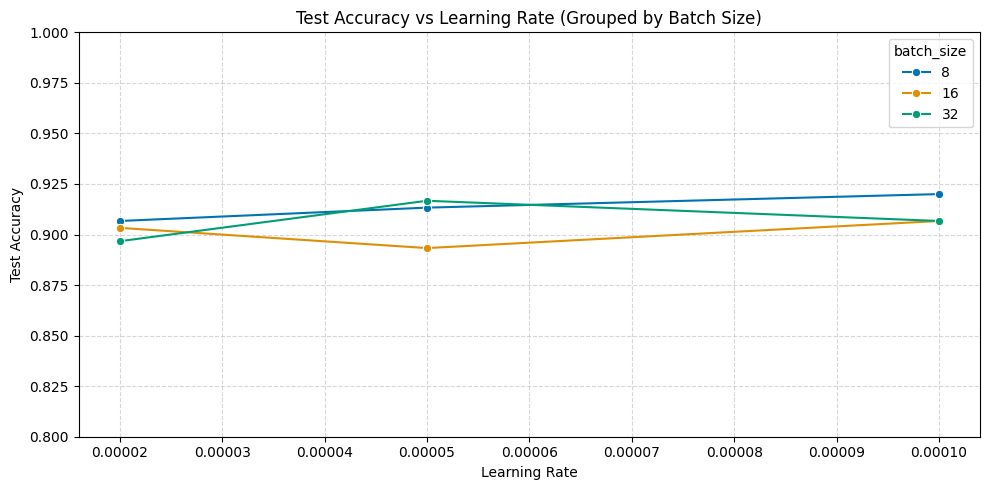

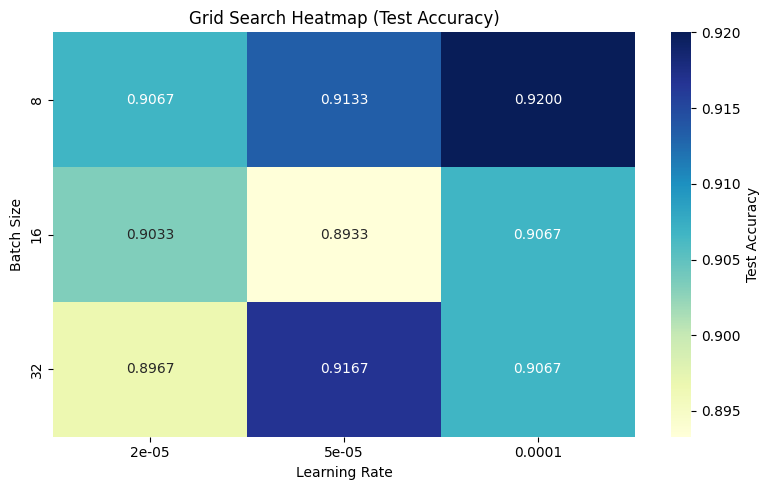

In [ ]:
# insert your code here

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert result list to DataFrame
df = pd.DataFrame(results)
df = df.rename(columns={"accuracy": "Test Accuracy"})  # For cleaner labels

# ---- 1. Summary Table ----
print("### Test Accuracy (Sorted by Performance)")
df_sorted = df.sort_values(by="Test Accuracy", ascending=False)
from tabulate import tabulate
print(tabulate(df_sorted, headers="keys", tablefmt="github", showindex=False))
print()

# ---- 2. Line Plot ----
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=df,
    x="learning_rate",
    y="Test Accuracy",
    hue="batch_size",
    marker="o",
    palette="colorblind"
)
plt.title("Test Accuracy vs Learning Rate (Grouped by Batch Size)")
plt.xlabel("Learning Rate")
plt.ylabel("Test Accuracy")
plt.ylim(0.8, 1.0)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
print()

# ---- 3. Heatmap ----
# Pivot table for heatmap
pivot = df.pivot(index="batch_size", columns="learning_rate", values="Test Accuracy")
plt.figure(figsize=(8, 5))
sns.heatmap(
    pivot,
    annot=True,
    fmt=".4f",
    cmap="YlGnBu",
    cbar_kws={"label": "Test Accuracy"}
)
plt.title("Grid Search Heatmap (Test Accuracy)")
plt.xlabel("Learning Rate")
plt.ylabel("Batch Size")
plt.tight_layout()
plt.show()


### **Evaluation of Fine-Tuning Hyperparameters: Batch Size & Learning Rate**
---

This section presents both **generalized insights** and **empirical findings** from a grid search over different **batch sizes** and **learning rates** for fine-tuning DistilBERT on the **Yelp Polarity** sentiment classification task.  
Each model was trained on all **300 training samples** and evaluated on the **300-example test set** after each epoch.

---

### **Generalized Impact of Hyperparameters (Condensed)**

- **Batch Size**:
  - Smaller batches (8, 16) introduce more gradient noise, which can enhance generalization by acting as implicit regularization.
  - Larger batches (32) yield smoother updates and faster convergence, but are more sensitive to learning rate and may generalize worse.

- **Learning Rate**:
  - Lower rates (2e-5) are often too slow within short training windows.
  - Higher rates (5e-5 to 1e-4) enable faster learning, but can destabilize training when paired with small batches.

---

### **Grid Search Results (Sorted by Final Test Accuracy)**

| **Batch Size** | **Learning Rate** | **Test Accuracy (%)** |
|----------------|--------------------|------------------------|
| 8              | 1e-4               | **92.00**             |
| 32             | 5e-5               | 91.67                 |
| 8              | 5e-5               | 91.33                 |
| 8              | 2e-5               | 90.67                 |
| 16             | 1e-4               | 90.67                 |
| 32             | 1e-4               | 90.67                 |
| 16             | 2e-5               | 90.33                 |
| 32             | 2e-5               | 89.67                 |
| 16             | 5e-5               | 89.33                 |

---

### **Insights from the Results**

- A consistent pattern emerged for fixed learning rates (except 5e-5):  
  **Test accuracy improves as batch size decreases** → **32 < 16 < 8**.  
  This confirms that **smaller batches improve generalization**, likely due to their noisier gradient updates and implicit regularization effect.

- The top-performing configuration was **batch size 8 with learning rate 1e-4** (92.00%). This setting likely benefited from fast convergence and strong generalization, making the most of the limited training epochs.

- **Batch size 8** performed well across *all* learning rates, suggesting it is a robust default in small-data regimes — even when paired with aggressive learning rates.

- **Batch size 32** showed high variance: it performed well with 5e-5 (91.67%) but dropped significantly at 2e-5 (89.67%). This confirms that **larger batches require more careful learning rate tuning** and are prone to underfitting when paired with conservative settings.

- Interestingly, the commonly used combination **batch size 16 with learning rate 5e-5** produced the lowest accuracy (89.33%). This highlights that "typical defaults" may not be optimal in data-limited settings.

- The exception to the trend occurred at **learning rate 5e-5**, where batch size 32 surprisingly outperformed batch sizes 16 and 8. This may reflect a sweet spot where the larger batch stabilized training while still benefiting from a moderately high learning rate — avoiding both under- and overfitting.

- In short, **small batches consistently outperformed larger ones**, and **1e-4 was the most effective learning rate** overall. These patterns align with known behaviors in low-resource fine-tuning and emphasize the importance of batch size–learning rate interplay.



## **Part B: Using Fine-Tuned Models on New Tasks**
---

In this part of the assignment, you do **not** need to perform any training on language models.  
Instead, we will leverage the capabilities of **transfer learning** to address more complex language tasks by reducing them to classic tasks such as **text classification**, **natural language inference**, **question answering**, and others.

For example, fine-tuned models for [**text classification**](https://huggingface.co/tasks/text-classification) can be used to handle tasks like:

- Are two given sentences paraphrases of each other? → **[Paraphrase / No Paraphrase]**
- Does sentence X entail sentence Y? → **[Entail / Neutral / Contradict]**
- Is the given sentence grammatically correct? → **[Acceptable / Unacceptable]**


## **B1. Piqa Dataset**
---

The [**Piqa dataset**](https://huggingface.co/datasets/piqa) contains prompts designed to assess the extent to which **language models possess commonsense knowledge**. Specifically, it consists of incomplete sentences and multiple possible endings, where choosing the correct ending requires **commonsense reasoning**.

For example, given the sentence:  
**"When boiling butter, when it's ready, you can"**  
There are two candidate endings:
- **"Pour it onto a plate"**
- **"Pour it into a jar"**

A human can infer that the **second sentence** is the more appropriate ending, since **melted butter is a liquid**, and therefore **a jar is a more suitable container than a plate**.

To speed up processing, select a **random subset of 100 samples** from the Piqa dataset.


### **Load and Sample the Dataset**
---

This cell performs the following:

- Loads the **PiQA** commonsense reasoning dataset using the Hugging Face `datasets` library.
- Randomly samples **100 examples** from the validation split.
- Uses a fixed `seed=42` to ensure **reproducibility** of the subset across runs.


In [ ]:
# insert your code here (load dataset)

from datasets import load_dataset

# Load the PiQA dataset
piqa_dataset = load_dataset("piqa", trust_remote_code=True)

# Select a random 100-sample subset from the validation set
piqa_subset = piqa_dataset["validation"].shuffle(seed=42).select(range(100))


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.41k [00:00<?, ?B/s]

piqa.py:   0%|          | 0.00/5.36k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16113 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3084 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1838 [00:00<?, ? examples/s]

We can treat the above scenario as a **multiple-choice problem**, where there are **two possible alternatives** for the ending of a sentence. Therefore, by utilizing appropriate models, we can solve the task of **selecting the correct ending** given a prompt.

You are required to **record the accuracy** of ending predictions for each sentence using **language models**.  
For comparison purposes, use **at least 5 suitable models**.


### **Load Pretrained NLI Models**
---

This cell loads **seven** high-performing Natural Language Inference (NLI) models using the `transformers.pipeline` interface, optimized for transfer learning on the PiQA commonsense reasoning task:

- Each model performs **multi-class entailment classification** between a premise (goal) and a hypothesis (candidate ending), outputting labels like *entailment*, *neutral*, and *contradiction*.
- Pipelines are initialized with `device_map="auto"` to leverage **GPU acceleration** where available.
- `top_k=None` ensures that we receive **scores for all possible labels**, replacing the deprecated `return_all_scores=True`.
- The ensemble includes top models from the DeBERTa, RoBERTa, and BART families, all fine-tuned on high-quality datasets such as MNLI, FEVER, ANLI, and others.
- This setup avoids manual model/tokenizer management and offers a clean, efficient interface for zero-shot evaluation on PiQA.


In [ ]:
# Load 7 top-performing NLI/text-classification models
from transformers import pipeline

models = {
    "MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-ling-wanli": pipeline(
        "text-classification",
        model="MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-ling-wanli",
        device_map="auto",
        top_k=None
    ),
    "microsoft/deberta-v2-xlarge-mnli": pipeline(
        "text-classification",
        model="microsoft/deberta-v2-xlarge-mnli",
        device_map="auto",
        top_k=None
    ),
    "MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli": pipeline(
        "text-classification",
        model="MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli",
        device_map="auto",
        top_k=None
    ),
    "microsoft/deberta-large-mnli": pipeline(
        "text-classification",
        model="microsoft/deberta-large-mnli",
        device_map="auto",
        top_k=None
    ),
    "ynie/roberta-large-snli_mnli_fever_anli_R1_R2_R3-nli": pipeline(
        "text-classification",
        model="ynie/roberta-large-snli_mnli_fever_anli_R1_R2_R3-nli",
        device_map="auto",
        top_k=None
    ),
    "FacebookAI/roberta-large-mnli": pipeline(
        "text-classification",
        model="FacebookAI/roberta-large-mnli",
        device_map="auto",
        top_k=None
    ),
    "facebook/bart-large-mnli": pipeline(
        "text-classification",
        model="facebook/bart-large-mnli",
        device_map="auto",
        top_k=None
    ),
}


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/870M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/395 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.65M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/18.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

Device set to use cuda:0


config.json:   0%|          | 0.00/952 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.77G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.77G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.45M [00:00<?, ?B/s]

Device set to use cuda:0


config.json:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/369M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.66M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

Device set to use cuda:0


config.json:   0%|          | 0.00/729 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.62G [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

Device set to use cuda:0


config.json:   0%|          | 0.00/703 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

Some weights of the model checkpoint at ynie/roberta-large-snli_mnli_fever_anli_R1_R2_R3-nli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

Device set to use cuda:0


config.json:   0%|          | 0.00/688 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

Some weights of the model checkpoint at FacebookAI/roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


### **Predict the More Entailed Ending**
---

This function predicts which of the two PiQA endings is more plausible using a Natural Language Inference (NLI) model:

- Treats the **goal as the premise** and each candidate ending as a **hypothesis**.
- Uses `transformers.pipeline` with `top_k=None` to obtain scores for **all labels** (e.g. entailment, neutral, contradiction).
- For each pair, computes a **margin score**:  
  **Entailment score − Contradiction score**
- Selects the ending with the **higher margin**, which better reflects confidence in a correct entailment over a clear contradiction.
- Returns both the **predicted index** (0 or 1) and the **margin scores** for analysis.


In [ ]:
# insert your code here (function for ending prediction)

def predict_best_ending(model_pipeline, sample):
    """
    Given a Hugging Face NLI pipeline and one PiQA sample dict with keys
    'goal', 'sol1', and 'sol2', returns:
      - an integer 0 or 1 indicating which solution is predicted more likely,
      - the list of margin scores [margin_sol1, margin_sol2].

    Margin is defined as: P(entailment) - P(contradiction).
    """
    premise = sample["goal"]
    choices = [sample["sol1"], sample["sol2"]]

    # Prepare inputs for both endings
    inputs = [{"text": premise, "text_pair": choice} for choice in choices]

    # Run the pipeline and request all label scores
    # (assumes you initialized your pipelines with top_k=None)
    results = model_pipeline(inputs, top_k=None)

    margins = []
    for result in results:
        # Build a normalized label→score map
        label_scores = {entry["label"].lower(): entry["score"] for entry in result}
        entail = label_scores.get("entailment", 0.0)
        contra = label_scores.get("contradiction", 0.0)
        margins.append(entail - contra)

    # Choose the index with the higher margin
    best_idx = int(margins[1] > margins[0])
    return best_idx, margins



### **Evaluate Model Accuracy and Margin on PiQA**
---

This cell computes and displays both **prediction accuracy** and **average margin** for each model on the 100-example PiQA validation subset:

- Iterates over all loaded NLI models.
- For each model:
  - Runs `predict_best_ending()` on all samples to select the more plausible ending.
  - Records both the predicted index and the **margin score** for that prediction (`P(entailment) - P(contradiction)`).
- Compares predicted answers to ground truth labels to compute **accuracy**.
- Computes the **average margin** across all predictions to reflect the model’s confidence.
- Stores and prints results sorted by **descending accuracy**, including both accuracy and average margin.
- Uses `tqdm` to display a progress bar during evaluation.


In [ ]:
# Evaluate accuracy and average margin of each model on the PiQA subset

from tqdm.auto import tqdm

results_b1 = {}
margins_b1 = {}
n_samples = len(piqa_subset)

for name, clf in models.items():
    preds = []
    margin_values = []

    for sample in tqdm(piqa_subset, desc=f"Eval {name}", leave=False):
        pred, margins = predict_best_ending(clf, sample)
        preds.append(pred)
        margin_values.append(max(margins))  # take the stronger of the two margins

    labels = [sample["label"] for sample in piqa_subset]
    correct = sum(p == l for p, l in zip(preds, labels))

    results_b1[name] = round(correct / n_samples, 4)
    margins_b1[name] = round(sum(margin_values) / n_samples, 4)

# Display models sorted by descending accuracy
print("Model accuracies and average margins on PiQA subset:\n")
for model_name in sorted(results_b1, key=results_b1.get, reverse=True):
    acc = results_b1[model_name]
    margin = margins_b1[model_name]
    print(f"{model_name:<60} Accuracy = {acc:.4f}   Avg. Margin = {margin:.4f}")


Eval MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-ling-wanli:   0%|          | 0/100 [00:00<?, ?it/s]

Eval microsoft/deberta-v2-xlarge-mnli:   0%|          | 0/100 [00:00<?, ?it/s]

Eval MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli:   0%|          | 0/100 [00:00<?, ?it/s]

Eval microsoft/deberta-large-mnli:   0%|          | 0/100 [00:00<?, ?it/s]

Eval ynie/roberta-large-snli_mnli_fever_anli_R1_R2_R3-nli:   0%|          | 0/100 [00:00<?, ?it/s]

Eval FacebookAI/roberta-large-mnli:   0%|          | 0/100 [00:00<?, ?it/s]

Eval facebook/bart-large-mnli:   0%|          | 0/100 [00:00<?, ?it/s]

Model accuracies and average margins on PiQA subset:

MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-ling-wanli     Accuracy = 0.7900   Avg. Margin = -0.0067
microsoft/deberta-large-mnli                                 Accuracy = 0.7600   Avg. Margin = -0.0611
microsoft/deberta-v2-xlarge-mnli                             Accuracy = 0.7000   Avg. Margin = -0.0223
MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli                 Accuracy = 0.6900   Avg. Margin = -0.0736
facebook/bart-large-mnli                                     Accuracy = 0.6600   Avg. Margin = -0.0115
ynie/roberta-large-snli_mnli_fever_anli_R1_R2_R3-nli         Accuracy = 0.6300   Avg. Margin = -0.0687
FacebookAI/roberta-large-mnli                                Accuracy = 0.6300   Avg. Margin = -0.0126


### **Plot Model Accuracy and Margin Results**
---

This cell creates **two separate bar charts** to visualize model performance on the PiQA subset:

1. **Accuracy Plot**
   - Displays prediction accuracy for each model, sorted in descending order.
   - Helps identify which models are most successful at choosing the correct solution.
   - Accuracy values are shown above each bar for clarity.

2. **Margin Plot**
   - Shows the average **entailment vs. contradiction margin** per model (i.e., prediction confidence).
   - Models are sorted by average margin to highlight which ones make more decisive predictions.
   - Margin values are annotated directly on the bars.

Both plots:
- Use consistent styling, rotated x-axis labels, and grid lines for readability.
- Provide complementary insights: **accuracy** reflects correctness, while **margin** reflects confidence.


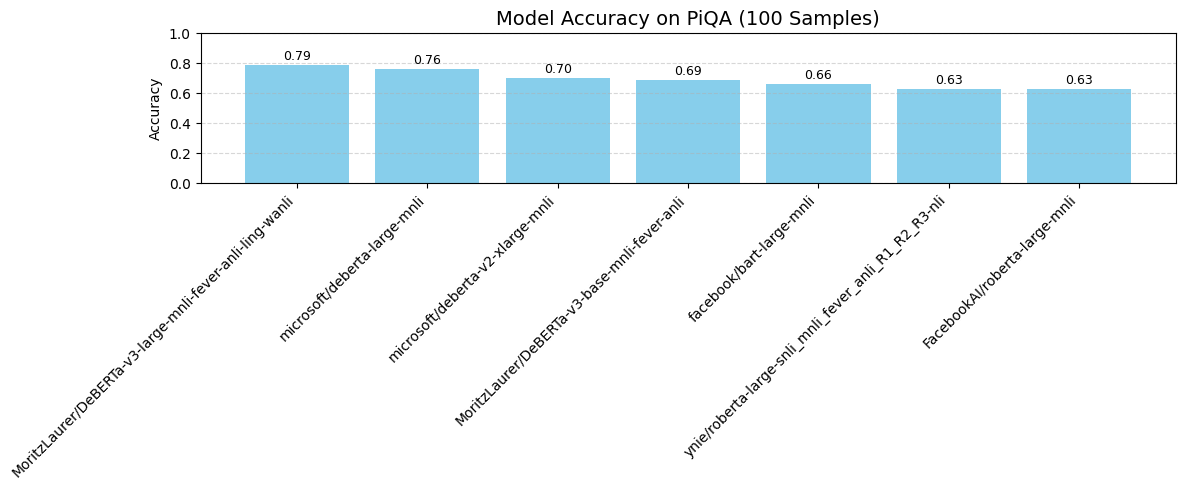

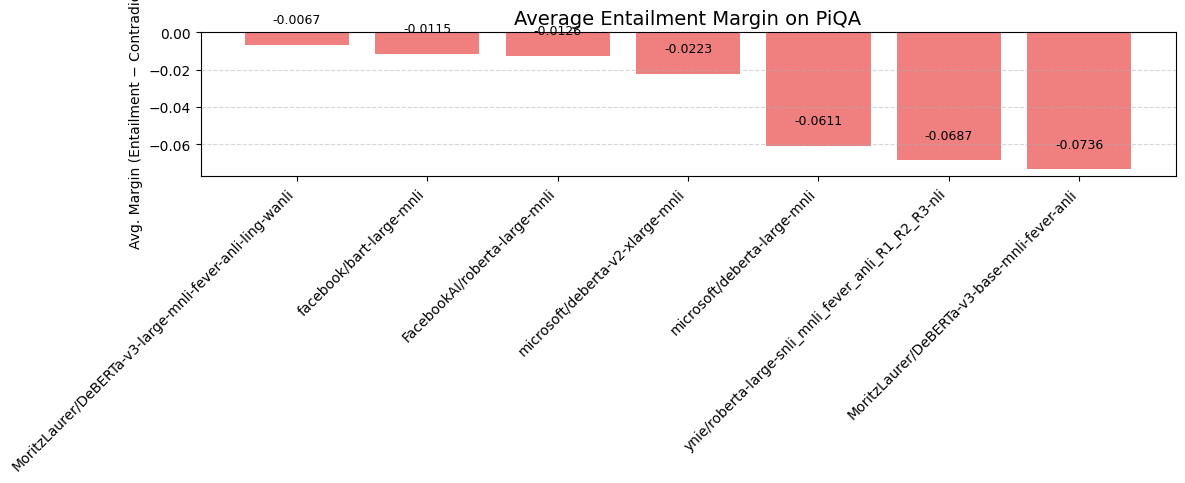

In [ ]:
# Visualize Accuracy and Margin Separately on PiQA

import matplotlib.pyplot as plt
import numpy as np

# Sort models by accuracy
sorted_acc = sorted(results_b1.items(), key=lambda x: x[1], reverse=True)
models_acc, accuracies = zip(*sorted_acc)

# Sort models by margin
sorted_margin = sorted(margins_b1.items(), key=lambda x: x[1], reverse=True)
models_margin, margins = zip(*sorted_margin)

# Plot Accuracy Chart
plt.figure(figsize=(12, 5))
bars = plt.bar(models_acc, accuracies, color='skyblue')
plt.title("Model Accuracy on PiQA (100 Samples)", fontsize=14)
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Add value labels
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, acc + 0.015, f"{acc:.2f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print()

# Plot Margin Chart
plt.figure(figsize=(12, 5))
bars = plt.bar(models_margin, margins, color='lightcoral')
plt.title("Average Entailment Margin on PiQA", fontsize=14)
plt.ylabel("Avg. Margin (Entailment − Contradiction)")
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Add value labels
for bar, margin in zip(bars, margins):
    plt.text(bar.get_x() + bar.get_width()/2, margin + 0.01, f"{margin:.4f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


### **Model Accuracy and Margin on PiQA Subset**
---

This evaluation compares 7 top-performing NLI models on a 100-example subset of the PiQA dataset — a benchmark for **physical commonsense reasoning**.  
We compute:

> - **Accuracy** — how often the model picks the correct answer  
> - **Margin** = P(entailment) − P(contradiction) — how confidently the model justifies its prediction

---

| **Model**                                                             | **Accuracy** | **Avg. Margin** |
|----------------------------------------------------------------------|--------------|-----------------|
| **MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-ling-wanli**         | **0.7900**   | **-0.0067**     |
| microsoft/deberta-large-mnli                                         | 0.7600       | -0.0611         |
| microsoft/deberta-v2-xlarge-mnli                                     | 0.7000       | -0.0223         |
| MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli                         | 0.6900       | -0.0736         |
| facebook/bart-large-mnli                                             | 0.6600       | -0.0115         |
| ynie/roberta-large-snli_mnli_fever_anli_R1_R2_R3-nli                 | 0.6300       | -0.0687         |
| FacebookAI/roberta-large-mnli                                        | 0.6300       | -0.0126         |

---

### **Understanding Margins**

- A **high positive margin** (near +1) means the model clearly favors entailment.
- A **margin near 0** means it’s unsure — assigning similar weight to both entailment and contradiction.
- A **negative margin** means the model leans toward contradiction — even if it selects the correct option.

---

### **Why Are Margins Negative Across the Board?**

1. **Training Misalignment:**  
   Models are trained on abstract NLI datasets (e.g., MNLI, ANLI), not grounded tasks like PiQA. They lack exposure to physical or causal logic.

2. **Contradiction Bias:**  
   Contradiction is overrepresented in training data. As a result, models often default to it — even for plausible statements.

3. **No Physical Reasoning:**  
   PiQA requires understanding actions, outcomes, and real-world feasibility. NLI models rely on surface-level textual patterns, not grounded knowledge.

4. Negative average margins mean the models **tend to assign higher probabilities to contradiction than to entailment — on average — even when the correct answer is entailment.**

---

### **So Why Do We Still See High Accuracy?**

Accuracy measures **which option ranks higher**, not how confident the model is:
- A model can choose the correct answer simply because its **margin is less negative** than the other one.
- This leads to good accuracy — but low or negative confidence.

Analogy:  
> *“I don’t really believe either choice is right, but this one seems slightly less wrong.”*

---

### **Model Comparisons**

- **MoritzLaurer/DeBERTa-v3-large** clearly leads in both accuracy and margin (least negative), showing the benefit of diverse fine-tuning (ANLI, FEVER, WANLI) and a strong DeBERTa v3 base.
- **microsoft/deberta-large-mnli** performs well in accuracy but has one of the most negative margins, suggesting it often gets it right **without believing in the answer**.
- **DeBERTa-v2-xlarge** underperforms despite its scale — fine-tuning quality matters more than size.
- **MoritzLaurer/DeBERTa-v3-base** delivers solid accuracy but has the most negative margin overall, showing it’s making good guesses with **very low confidence**.
- **RoBERTa and BART variants** (including fine-tuned ones like `ynie/roberta`) struggle in both accuracy and margin — likely due to insufficient exposure to **physical or causal inference** tasks.

---

### **Conclusion**

While NLI models can often **guess correctly**, they do so without **real confidence or justification**.  
Their **uniformly negative margins** reveal a mismatch between textual NLI training and real-world reasoning demands.

> *“These models succeed by elimination, not understanding.”*

To address this, future systems must be trained not just to recognize entailment in text — but to reason **about the world**, its objects, and their interactions.


## **B2. Truthful QA**
---

### **Sentence Transformers**
---

**Sentence transformers** are used to generate **sentence embeddings**, i.e., vector representations of sentences in a vector space.  
Thanks to the way they are pretrained, they have the ability to **place semantically similar sentences close to each other**, while pushing **semantically distant sentences further apart**.  
As a result, the representations we obtain from sentence embeddings allow us to assess **how semantically close or distant two sentences are**.

The comparison of these vector representations can be done using standard methods such as **cosine similarity**, where **higher values** between vectors indicate **greater similarity**, and thus **more similar sentences**.  
For this reason, we provide a function that computes cosine similarity.


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
def get_cosine_similarity(feature_vec_1, feature_vec_2):
    return cosine_similarity(feature_vec_1.reshape(1, -1), feature_vec_2.reshape(1, -1))[0][0]

For example, run the following cell, which returns a **similarity score in the range $[0, 1]$** for the two sentences:  
**"This is an example sentence"** and **"Each sentence is converted"**.  

You can also try running the same cell with **different sentence pairs** of your choice — which may be similar or very different from each other — and observe how the **cosine similarity values change** accordingly.


In [ ]:
from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
embeddings = model.encode(sentences)

get_cosine_similarity(embeddings[0], embeddings[1])

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

np.float32(0.4048847)

For the next part of the exercise, you are required to **select at least 6 different [models for semantic similarity](https://huggingface.co/models?pipeline_tag=sentence-similarity&sort=downloads)** from the **Sentence Transformers**.


### **Can Question Answering Models Distinguish True from False Statements?**
---

This is the question we will investigate in this part of the exercise.  
To do so, we will load the [**Truthful QA generation**](https://huggingface.co/datasets/truthful_qa/viewer/generation/validation) dataset, which includes the following answer types:

- **best answer**
- **correct answer**
- **incorrect answer**

Often, the **best answer** and **correct answer** are either the same or very similar in meaning. This is where we will make use of **semantic similarity** to assess this closeness.

We filter the dataset to contain **100 samples** for efficiency.  
Each sample must include **at least 2 correct answers**, leading to the following 4 candidate choices:

1. **1st choice**: best answer  
2. **2nd choice**: 1st correct answer  
3. **3rd choice**: 2nd correct answer  
4. **4th choice**: incorrect answer  

These choices, along with the question, are passed to a **multiple-choice model**, like those used in **Question B1**. You may reuse those models and extend them to handle 4 candidate answers.

**Semantic similarity** affects what we consider to be an optimally correct answer — and therefore also impacts **accuracy**.  
Specifically, we will generate **vector representations** (embeddings) for the **best answer** and the two **correct answers** using a semantic similarity model.  

If the multiple-choice model selects one of the **correct answers**, and its **cosine similarity with the best answer exceeds a threshold**, we count it as optimally correct.  
We define this **similarity threshold as 0.95**.

**Example:**  
Suppose the model selects the 2nd choice (1st correct answer), and the **cosine similarity** between the **best answer** and the **1st correct** is **> 0.95**.  
In this case, the answer is counted as **optimally correct**, and contributes positively to the model's **accuracy**.

You are required to write a **function** that computes the **accuracy of selecting optimally correct answers** from the candidate answers.  
Evaluate your approach using **at least 6 semantic similarity models**, as well as the **multiple-choice models** used in **Question B1**.


### **Load and Sample the TruthfulQA Dataset**
---

This cell:

- Loads the **TruthfulQA generation** dataset from Hugging Face.
- Filters the validation set to include only samples that:
  - Include a `best_answer`, and
  - Contain **at least 2 correct** and **2 incorrect answers**.
- Shuffles the filtered dataset using `seed=42` for reproducibility.
- Selects up to **100 valid samples** for efficient evaluation in Part B2.


In [ ]:
from datasets import load_dataset

# Load the TruthfulQA *generation* dataset
truthful_qa = load_dataset("truthful_qa", "generation")

# Filter for samples with a best answer, 2+ correct, and 2+ incorrect answers
valid_samples = truthful_qa["validation"].filter(
    lambda ex: "best_answer" in ex
    and len(ex["correct_answers"]) >= 2
    and len(ex["incorrect_answers"]) >= 2
)

# Print how many valid samples we have
print(f"Found {len(valid_samples)} valid samples.")

# Select up to 100 samples for evaluation
truthful_qa_subset = valid_samples.shuffle(seed=42).select(range(min(100, len(valid_samples))))
print(f"Selected {len(truthful_qa_subset)} samples for evaluation.")


validation-00000-of-00001.parquet:   0%|          | 0.00/223k [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/817 [00:00<?, ? examples/s]

Filter:   0%|          | 0/817 [00:00<?, ? examples/s]

Found 715 valid samples.
Selected 100 samples for evaluation.


### **Load Semantic Similarity and QA Models**
---

This cell:

- Loads **seven SentenceTransformer models** for computing **semantic similarity** via vector embeddings.
  - These include general-purpose (`MiniLM`, `MPNet`), **QA-optimized**, and **STSB-tuned** variants.
  - They will be used to compare candidate answers to the gold "best answer" using **cosine similarity**.

- Reuses the **seven QA/NLI pipelines** from Part B1, stored in `qa_models`.
  - These are Hugging Face `text-classification` pipelines that predict entailment-style scores between a question and each answer option.
  - These models are used to select which of the four candidate answers is most likely to be correct.

Together, these model types will be paired to evaluate **optimal correctness** based on:
- The answer **selected by the QA model**, and
- Its **semantic similarity** to the best answer.


In [ ]:
# insert your code here (load models for semantic similarity and QA)

from transformers import pipeline
from sentence_transformers import SentenceTransformer

# Load 7 Top Semantic-Similarity Models
similarity_models = {
    "all-MiniLM-L6-v2": SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2"),
    "all-mpnet-base-v2": SentenceTransformer("sentence-transformers/all-mpnet-base-v2"),
    "paraphrase-MiniLM-L6-v2": SentenceTransformer("sentence-transformers/paraphrase-MiniLM-L6-v2"),
    "paraphrase-mpnet-base-v2": SentenceTransformer("sentence-transformers/paraphrase-mpnet-base-v2"),
    "multi-qa-MiniLM-L6-cos-v1": SentenceTransformer("sentence-transformers/multi-qa-MiniLM-L6-cos-v1"),
    "multi-qa-mpnet-base-dot-v1": SentenceTransformer("sentence-transformers/multi-qa-mpnet-base-dot-v1"),
    "stsb-roberta-large": SentenceTransformer("sentence-transformers/stsb-roberta-large", device="cpu")
}

# Reuse the 7 QA/NLI pipelines from B1
qa_models = models


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.51k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.52k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/594 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/11.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/383 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/8.71k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.75k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/674 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

### **Compute Optimal Accuracy with QA + Semantic Similarity**
---

This function evaluates the combined performance of a **QA/NLI model** and a **semantic similarity model** on TruthfulQA:

- Each question is paired with **4 answers** (2 correct, 2 incorrect), shuffled per sample.
- The **QA model** ranks all options using their **entailment scores**, selecting the most likely answer.
- If the chosen answer is among the correct ones:
  - The **similarity model** encodes both the selected answer and the gold `best_answer`.
  - Their **cosine similarity** is computed; the prediction is only accepted if similarity ≥ 0.95.
- This ensures that a model is rewarded not just for picking a factually correct answer, but for choosing one that is **semantically close** to the ideal.

The final score reflects both **logical correctness** (via QA) and **semantic alignment** (via similarity).


In [ ]:
# insert your code here (function for optimal correct answers & semantic similarity)

from sklearn.metrics.pairwise import cosine_similarity
import random

def get_cosine_similarity(vec1, vec2):
    """
    Compute cosine similarity between two 1D feature vectors.
    """
    return cosine_similarity(vec1.reshape(1, -1), vec2.reshape(1, -1))[0][0]

def evaluate_optimal_accuracy(mc_model, sim_model, dataset, threshold=0.95, seed=42):
    """
    For each sample in `dataset`, run the multiple-choice model `mc_model` over
    four options (2 correct, 2 incorrect), then:
      1. Check if the model’s top-entailment pick is one of the correct answers.
      2. If so, compute cosine similarity between that pick and the 'best_answer'
         using `sim_model`.
      3. Count it as ‘optimally correct’ only if sim ≥ threshold.

    Returns the proportion of samples that are optimally correct, rounded to 4 dp.
    """
    rng = random.Random(seed)
    optimal_correct = 0
    total = 0

    for sample in dataset:
        question    = sample["question"]
        best_ans    = sample["best_answer"]
        correct_two = sample["correct_answers"][:2]
        wrong_two   = sample["incorrect_answers"][:2]

        # Pair each option with a flag, then shuffle
        items = [(opt, True) for opt in correct_two] + [(opt, False) for opt in wrong_two]
        rng.shuffle(items)
        options, is_correct = zip(*items)

        # Prepare inputs for the NLI pipeline
        inputs = [{"text": question, "text_pair": opt} for opt in options]
        # Force top_k=None to get all label scores
        results = mc_model(inputs, top_k=None)

        # Extract entailment score per option
        entail_scores = []
        for res in results:
            label_map = {e["label"].lower(): e["score"] for e in res}
            entail_scores.append(label_map.get("entailment", 0.0))

        # Pick the option with highest entailment
        selected_idx = int(max(range(len(entail_scores)), key=entail_scores.__getitem__))

        # If it was one of the correct answers, check similarity
        if is_correct[selected_idx]:
            sel_emb  = sim_model.encode(options[selected_idx])
            best_emb = sim_model.encode(best_ans)
            sim      = get_cosine_similarity(sel_emb, best_emb)
            if sim >= threshold:
                optimal_correct += 1

        total += 1

    return round(optimal_correct / total, 4)


### **Evaluate Optimal Accuracy for All Model Pairs**
---

This cell:

- Evaluates **all combinations** of QA models and semantic similarity models on `truthful_qa_subset`.
- Displays a **progress bar** (`tqdm`) to track evaluation progress across all pairs.
- For each pair:
  - Uses `evaluate_optimal_accuracy()` to check whether the QA model selects a correct answer that is also **semantically close** to the `best_answer` (similarity ≥ 0.95).
- Stores results in a **Pandas DataFrame** (`df_results_b2`) with columns:
  - `QA Model`, `Similarity Model`, and `Optimal Accuracy`.

Additionally:

- Prints the **full results table**.
- Prints the **best QA model per similarity model**.
- Prints the **best similarity model per QA model**.

This extended reporting supports both **overall comparisons** and **model pairing analysis**, revealing where semantic models best complement QA systems.


In [ ]:
# Evaluate optimal accuracy across QA × Similarity model pairs

import pandas as pd
import itertools
from tqdm.auto import tqdm

results_b2 = []

# Prepare all (QA model, Similarity model) pairs
pairs = list(itertools.product(qa_models.items(), similarity_models.items()))

# Evaluate all combinations
for (qa_name, qa_model), (sim_name, sim_model) in tqdm(
    pairs,
    desc="Evaluating QA × Similarity",
    total=len(pairs),
    leave=True
):
    acc = evaluate_optimal_accuracy(qa_model, sim_model, truthful_qa_subset)
    results_b2.append({
        "QA Model": qa_name,
        "Similarity Model": sim_name,
        "Optimal Accuracy": acc
    })

# Store results as DataFrame
df_results_b2 = pd.DataFrame(results_b2)

# Print full table (optional)
print("\nRaw Results (Full Table):")
print(df_results_b2)

# Print: Top QA model per similarity model
print("\nTop QA model per Similarity Model:")
top_per_sim = df_results_b2.loc[df_results_b2.groupby("Similarity Model")["Optimal Accuracy"].idxmax()]
print(top_per_sim.sort_values("Optimal Accuracy", ascending=False))

# Print: Best similarity model per QA model
print("\nBest Similarity model per QA Model:")
top_per_qa = df_results_b2.loc[df_results_b2.groupby("QA Model")["Optimal Accuracy"].idxmax()]
print(top_per_qa.sort_values("Optimal Accuracy", ascending=False))


Evaluating QA × Similarity:   0%|          | 0/49 [00:00<?, ?it/s]


Raw Results (Full Table):
                                             QA Model  \
0   MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-...   
1   MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-...   
2   MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-...   
3   MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-...   
4   MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-...   
5   MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-...   
6   MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-...   
7                    microsoft/deberta-v2-xlarge-mnli   
8                    microsoft/deberta-v2-xlarge-mnli   
9                    microsoft/deberta-v2-xlarge-mnli   
10                   microsoft/deberta-v2-xlarge-mnli   
11                   microsoft/deberta-v2-xlarge-mnli   
12                   microsoft/deberta-v2-xlarge-mnli   
13                   microsoft/deberta-v2-xlarge-mnli   
14       MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli   
15       MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli   
16  

### **Visualize Optimal Accuracy Results**
---

This cell generates four charts to compare model performance on TruthfulQA:

1. **Grouped Bar Chart** – Shows optimal accuracy for each QA × similarity model pair, with value labels.

2. **Top QA per Similarity Model** – Highlights which QA model performs best with each similarity model (sorted).

3. **Best Similarity per QA Model** – Shows which similarity model yields the best result for each QA model (sorted).

4. **Heatmap** – Full matrix of all model pair accuracies for detailed comparison.

All bars are labeled for clarity and charts are sorted to improve readability.


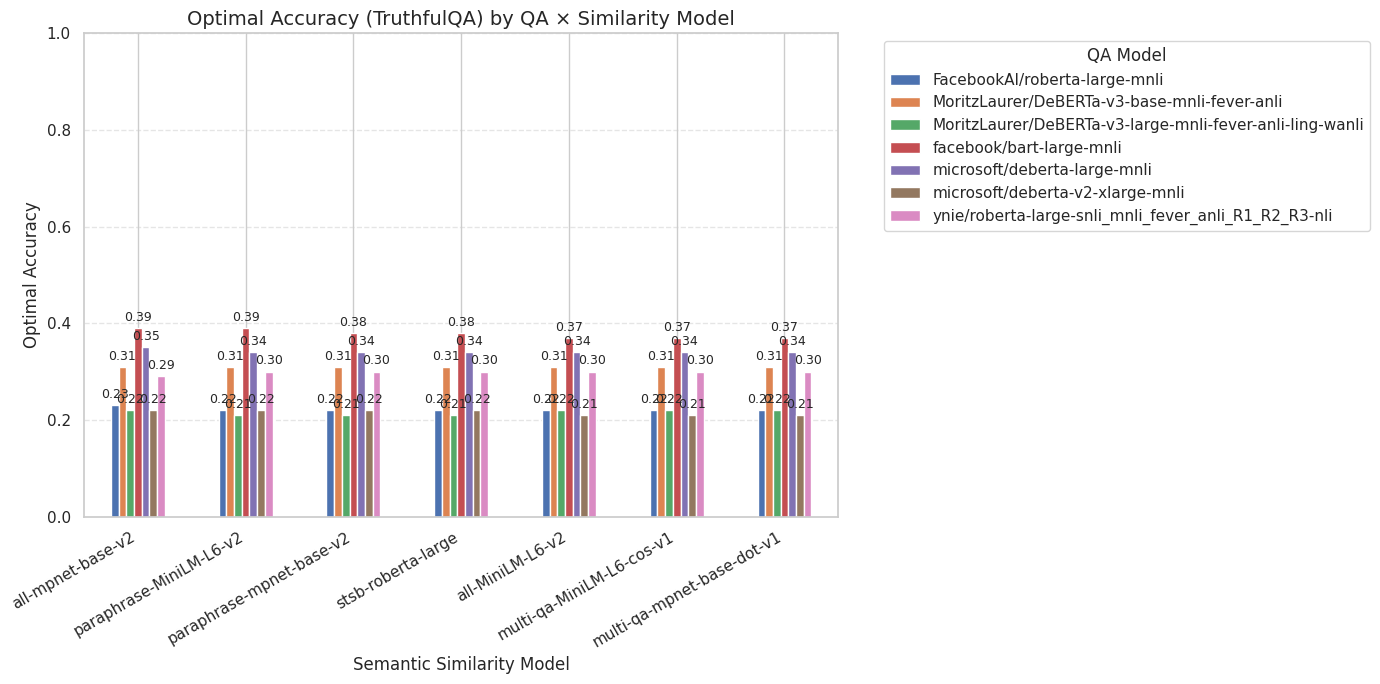

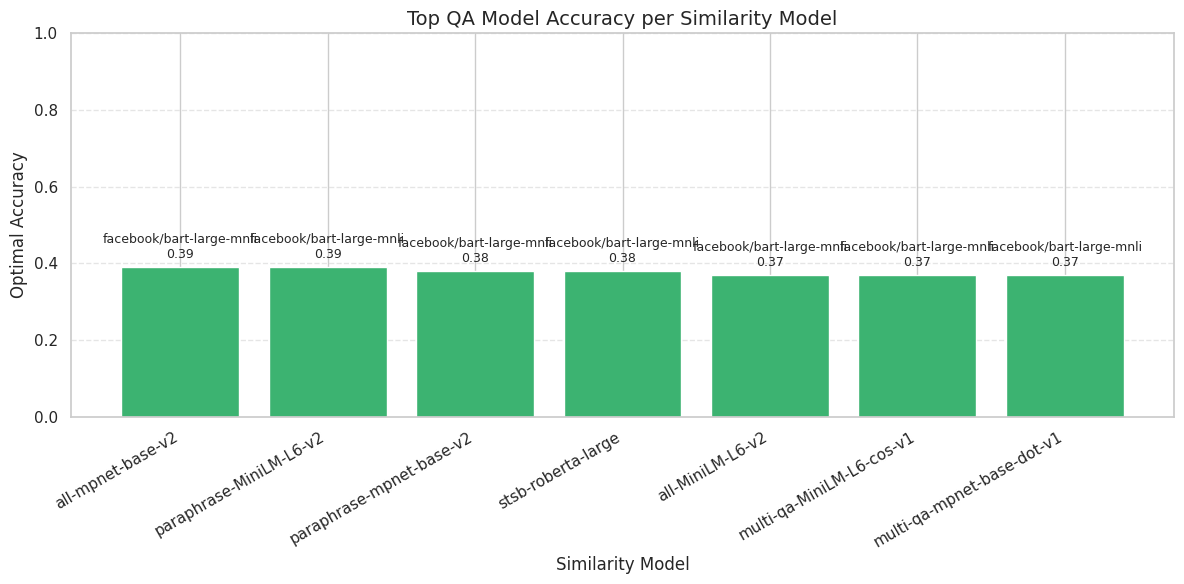

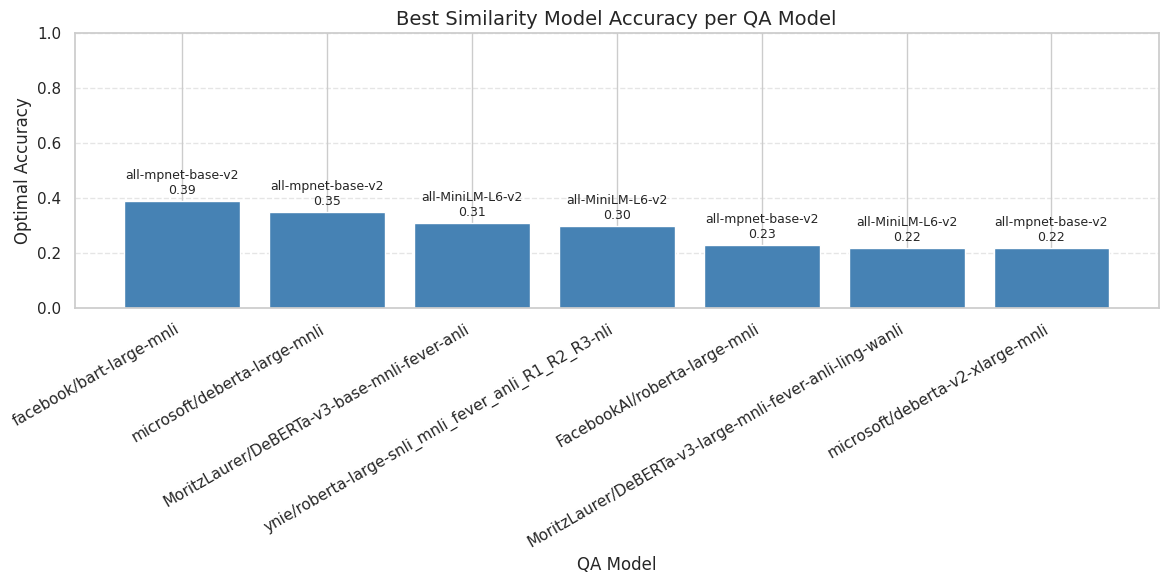

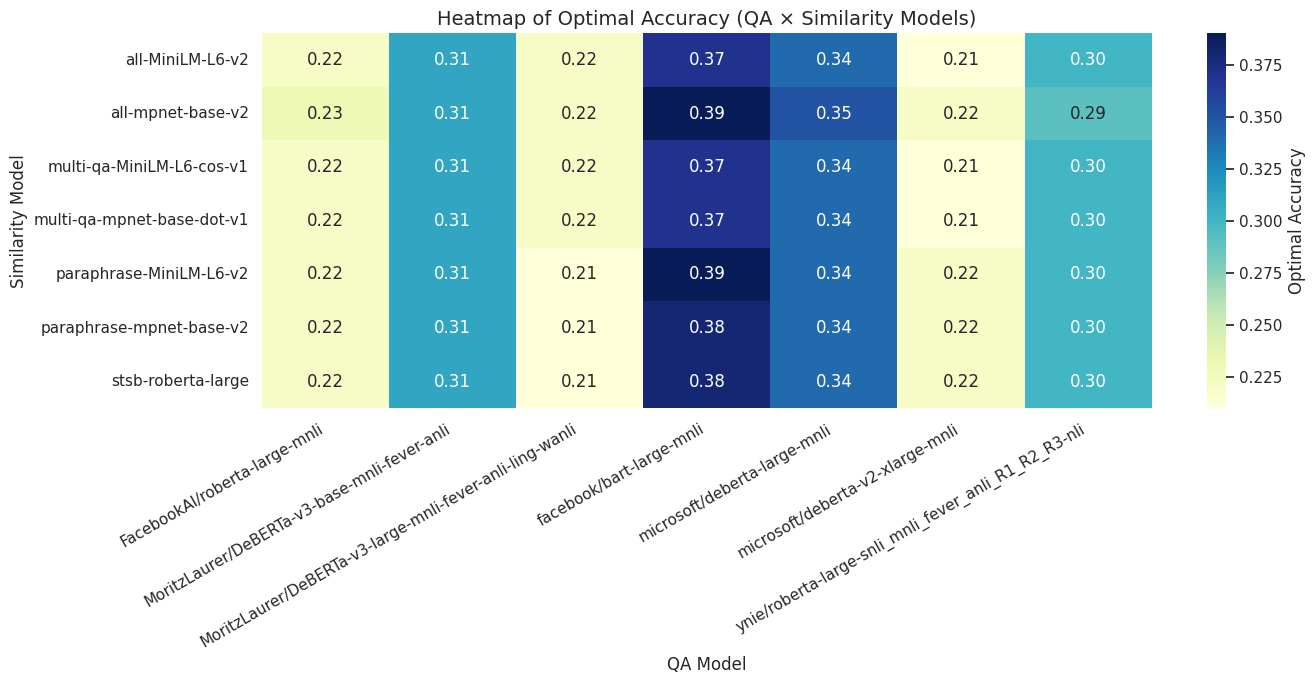

In [ ]:
# === Visualize Optimal Accuracy: Multiple Charts (Sorted) ===

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid")

# 1. Grouped bar chart (QA × Similarity accuracy)
pivot_df = df_results_b2.pivot(
    index="Similarity Model",
    columns="QA Model",
    values="Optimal Accuracy"
)

# Sort rows by mean accuracy (optional but clearer)
pivot_df = pivot_df.loc[pivot_df.mean(axis=1).sort_values(ascending=False).index]

# Plot grouped bar chart using pivot_df
ax = pivot_df.plot(kind="bar", figsize=(14, 7))
ax.set_title("Optimal Accuracy (TruthfulQA) by QA × Similarity Model", fontsize=14)
ax.set_xlabel("Semantic Similarity Model")
ax.set_ylabel("Optimal Accuracy")
ax.set_ylim(0, 1)
ax.grid(axis="y", linestyle="--", alpha=0.5)
plt.xticks(rotation=30, ha="right")

# Add accuracy labels
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", padding=3, fontsize=9)

ax.legend(title="QA Model", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()
print()

# 2. Top QA model per similarity model (sorted descending)
top_per_sim = df_results_b2.loc[df_results_b2.groupby("Similarity Model")["Optimal Accuracy"].idxmax()]
top_per_sim = top_per_sim.sort_values("Optimal Accuracy", ascending=False)

plt.figure(figsize=(12, 6))
bars = plt.bar(top_per_sim["Similarity Model"], top_per_sim["Optimal Accuracy"], color='mediumseagreen')

plt.title("Top QA Model Accuracy per Similarity Model", fontsize=14)
plt.xlabel("Similarity Model")
plt.ylabel("Optimal Accuracy")
plt.xticks(rotation=30, ha="right")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.5)

for bar, qa_name, acc in zip(bars, top_per_sim["QA Model"], top_per_sim["Optimal Accuracy"]):
    plt.text(bar.get_x() + bar.get_width() / 2, acc + 0.015, f"{qa_name}\n{acc:.2f}",
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()
print()

# 3. Best similarity model per QA model (sorted descending)
top_per_qa = df_results_b2.loc[df_results_b2.groupby("QA Model")["Optimal Accuracy"].idxmax()]
top_per_qa = top_per_qa.sort_values("Optimal Accuracy", ascending=False)

plt.figure(figsize=(12, 6))
bars = plt.bar(top_per_qa["QA Model"], top_per_qa["Optimal Accuracy"], color='steelblue')

plt.title("Best Similarity Model Accuracy per QA Model", fontsize=14)
plt.xlabel("QA Model")
plt.ylabel("Optimal Accuracy")
plt.xticks(rotation=30, ha="right")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.5)

for bar, sim_name, acc in zip(bars, top_per_qa["Similarity Model"], top_per_qa["Optimal Accuracy"]):
    plt.text(bar.get_x() + bar.get_width() / 2, acc + 0.015, f"{sim_name}\n{acc:.2f}",
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()
print()

# 4. Heatmap of QA × Similarity combinations
heat_df = df_results_b2.pivot(index="Similarity Model", columns="QA Model", values="Optimal Accuracy")

plt.figure(figsize=(14, 7))
sns.heatmap(heat_df, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={"label": "Optimal Accuracy"})
plt.title("Heatmap of Optimal Accuracy (QA × Similarity Models)", fontsize=14)
plt.ylabel("Similarity Model")
plt.xlabel("QA Model")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


### **Overall Results: TruthfulQA with QA + Semantic Similarity**
---

This evaluation assesses whether top NLI models can not only select the **correct answer**, but also one that is **semantically aligned** with the gold-standard `best_answer` in the **TruthfulQA** dataset.

A prediction is marked **optimally correct** only if:
- The model selects one of the two correct answers, **and**
- Its cosine similarity to the best answer (using a sentence transformer) is **≥ 0.95**.

---

#### **What the Heatmap Shows**

The heatmap visualizes the **optimal accuracy** across all combinations of QA and similarity models. Each row corresponds to a similarity model, each column to a QA model. Darker shades (toward black) indicate **higher optimal accuracy**, while lighter shades show weaker model combinations.

It reveals:
- No universally strong pair — even the best-performing combinations top out at **0.39**.
- Broad performance clustering around **0.22–0.31**, with few outliers.
- For a **fixed QA model**, the performance across all similarity models is nearly identical. This implies that the **QA model dominates** the final performance, and similarity model choice has limited influence.

---

#### **Top QA Models per Similarity Model**

When fixing the similarity model, the highest-performing QA model was usually:

- `facebook/bart-large-mnli`, reaching **0.39** with `all-mpnet-base-v2` and `paraphrase-MiniLM-L6-v2`
- `microsoft/deberta-large-mnli` followed closely in most rows (e.g., 0.35 with `all-mpnet-base-v2`)

This suggests that **BART** and **DeBERTa-large** generalize better across different similarity models.

---

#### **Top Similarity Models per QA Model**

When fixing the QA model, the best similarity model was often:

- `all-mpnet-base-v2` or `paraphrase-MiniLM-L6-v2`, performing best for 5 of the 7 QA models
- These models yield **more reliable similarity scores** when computing closeness to the best answer

---

#### **Average QA vs Similarity Model Performance**

Aggregating across rows and columns reveals a subtle but useful distinction:
- **Averaging across similarity models**, `facebook/bart-large-mnli` and `microsoft/deberta-large-mnli` consistently lead — they are **strong QA selectors** regardless of how similarity is measured.
- **Averaging across QA models**, `all-mpnet-base-v2`, `paraphrase-MiniLM-L6-v2`, and `stsb-roberta-large` produce the highest average accuracies — indicating they **best align correct answers** with the gold answer.

In short: strong QA models dominate the selection step, while similarity models provide consistent but less decisive support.

---

#### **Why Are Scores So Low?**

1. **Semantic threshold is strict**: Many correct answers use phrasing that differs too much from the gold `best_answer`, failing the cosine threshold.

2. **NLI model training mismatch**: Models trained on MNLI or ANLI are good at linguistic entailment but not factual correctness or trustworthiness.

3. **TruthfulQA is adversarial**: It includes distractors crafted to mislead models that rely on surface-level reasoning.

4. **Low confidence overall**: Even when models guess correctly, they often assign low entailment and high contradiction scores — indicating **uncertainty**.

---

#### **Conclusion**

Most models achieve **moderate raw accuracy**, but struggle to produce answers that are **both factually correct and semantically aligned**. The strict evaluation exposes gaps in both **confidence** and **factual reasoning**.

Bridging this gap will require:
- Training on **fact-grounded, paraphrase-rich corpora**
- QA systems that **reason over meaning**, not just form
- Better integration between selection and semantic verification components


## **Β3. Winogrande dataset**
---

The [**Winogrande dataset**](https://huggingface.co/datasets/winogrande) consists of sentences where **one word has been removed**, and two possible options are provided to fill in the blank.  

For example, given the sentence:  
**"John moved the couch from the garage to the backyard to create space. The _ is small."**  
there are two possible alternatives:

- **"garage"**  
- **"backyard"**

The challenge lies in the fact that **both words appear in the sentence**, so the model must have strong **language understanding abilities** to choose the **semantically correct** completion.

To speed up processing, select a **random subset of 100 samples** from the **training set** of Winogrande.



### **PWinogrande: Dataset Loading**

This cell performs the following steps:

- **Loads the Winogrande XL dataset** using the Hugging Face `datasets` library.
- **Selects a random subset of 100 samples** from the **training split**, each of which includes:
  - A sentence with a blank to be filled (`sentence`).
  - Two candidate options (`option1` and `option2`) that could complete the sentence.
  - The correct label (`answer`), where:
    - `"1"` indicates `option1` is correct,
    - `"2"` indicates `option2` is correct.
- **Prints dataset details** to verify structure and content:
  - Total number of samples in the full training set.
  - Size of the selected subset.
  - A sample entry showing how each field is structured.

**Why the training set?**

The **training split** provides labeled examples — both the inputs and the correct answers — which are essential for evaluating model accuracy on this task.


In [ ]:
# insert your code here (load dataset)

from datasets import load_dataset

# Load the Winogrande XL dataset, trusting remote code for proper parsing
winogrande = load_dataset("winogrande", "winogrande_xl", trust_remote_code=True)

# Select 100 random samples from the training set
winogrande_subset = winogrande["train"].shuffle(seed=42).select(range(100))

# Output dataset info
print("Dataset loaded:", winogrande)
print("Training split size:", len(winogrande["train"]))
print("Subset size:", len(winogrande_subset))
print("Example sample:\n", winogrande_subset[0])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.97k [00:00<?, ?B/s]

winogrande.py:   0%|          | 0.00/5.65k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/40398 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1767 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1267 [00:00<?, ? examples/s]

Dataset loaded: DatasetDict({
    train: Dataset({
        features: ['sentence', 'option1', 'option2', 'answer'],
        num_rows: 40398
    })
    test: Dataset({
        features: ['sentence', 'option1', 'option2', 'answer'],
        num_rows: 1767
    })
    validation: Dataset({
        features: ['sentence', 'option1', 'option2', 'answer'],
        num_rows: 1267
    })
})
Training split size: 40398
Subset size: 100
Example sample:
 {'sentence': "The phone of Donald is a lot better than Adam's because _ paid extra for his phone.", 'option1': 'Donald', 'option2': 'Adam', 'answer': '1'}


By applying an appropriate [**transformation**](https://huggingface.co/DeepPavlov/roberta-large-winogrande) to the input (i.e., the sentence with a blank and two filling options), you are required to **record the accuracy** of models that solve the task by comparing the **predicted label** with the **true label**  
(**1**: first option, **2**: second option).

Essentially, you need to **reformulate the above task as a more classic NLP problem**.

Try **at least 3 suitable models** from Hugging Face to approach the **Winogrande problem**.  
We recommend using **pipelines** to simplify implementation.


### **Winogrande — Define Model Configurations**
---

This cell:

- **Specifies a range of strong NLP models** from the Hugging Face Hub, each associated with a distinct task type.
- Stores model names and task types in a configuration dictionary (`model_configs`) for clean and modular pipeline creation later.
- Covers a variety of strategies for solving the Winogrande challenge, including:
  - **Text classification** with task-specific fine-tuning (e.g., Winogrande classifier).
  - **Masked language modeling** using BERT and RoBERTa to predict missing words.
  - **Zero-shot reasoning** via MNLI-based models like BART and DeBERTa.
  - **Instruction-tuned text generation** using models like Flan-T5 and UnifiedQA for flexible prompting.

These configurations support a comparative evaluation across different model families and reasoning styles.

---

### **Model Types Used in Winogrande Evaluation**

- **Fill-Mask** (`fill-mask`)  
  Predicts the most likely word to replace a masked token (`[MASK]`) in context.  
  *Example models:* `bert-large-uncased-whole-word-masking`, `roberta-large`

- **Text Classification** (`text-classification`)  
  Predicts a class label (e.g., option 1 or 2) based on sentence input.  
  *Example model:* `DeepPavlov/roberta-large-winogrande`

- **Zero-Shot Classification** (`zero-shot-classification`)  
  Reformulates the task as an NLI problem to choose the most likely candidate label.  
  *Example models:* `facebook/bart-large-mnli`, `microsoft/deberta-v3-large`

- **Text-to-Text Generation** (`text2text-generation`)  
  Accepts a prompt with instructions and generates a full-text response.  
  *Example models:* `google/flan-t5-large`, `allenai/unifiedqa-t5-large`

Instruction tuning and prompt clarity play a significant role in the effectiveness of zero-shot and generative models.


In [ ]:
# insert your code here (load models)

from transformers import pipeline

# Define model names and tasks
# Includes better-performing and more instruction-aware models
model_configs = {
    # Text classification model fine-tuned on Winogrande
    "winogrande_classifier": {
        "task": "text-classification",
        "model": "DeepPavlov/roberta-large-winogrande"
    },

    # Classic masked language models
    "bert_fill_mask": {
        "task": "fill-mask",
        "model": "bert-large-uncased-whole-word-masking"
    },
    "roberta_fill_mask": {
        "task": "fill-mask",
        "model": "roberta-large"
    },

    # Zero-shot NLI model (can benefit from prompt tuning)
    "zero_shot_bart": {
        "task": "zero-shot-classification",
        "model": "facebook/bart-large-mnli"
    },

    # Instruction-tuned generative model — flexible and strong
    "flan_t5": {
        "task": "text2text-generation",
        "model": "google/flan-t5-large"
    },

    # Add UnifiedQA (T5 fine-tuned on QA-style tasks including Winogrande)
    "unifiedqa_t5_large": {
        "task": "text2text-generation",
        "model": "allenai/unifiedqa-t5-large"
    },

    # DeBERTa for strong commonsense classification (can also be used zero-shot)
    "deberta_mnli": {
        "task": "zero-shot-classification",
        "model": "microsoft/deberta-v3-large"
    }
}


### **Winogrande — Create Model Pipelines**
---

This cell:

- **Instantiates Hugging Face pipelines** for each model specified in the configuration dictionary from the previous cell.
- Uses the appropriate task (e.g., `text-classification`, `fill-mask`, `zero-shot-classification`, `text2text-generation`) for each model.
- Stores all initialized pipeline objects in a dictionary called `models`, keyed by their model identifiers.
- These pipelines enable efficient evaluation of the Winogrande task using different NLP strategies, such as prediction, masking, inference, and zero-shot reasoning.


In [ ]:
# insert your code here (create pipelines)

from transformers import pipeline

# Instantiate pipelines for all models in the configuration
winogrande_models = {}

for name, cfg in model_configs.items():
    try:
        print(f"Loading pipeline: {name} ({cfg['task']})")
        winogrande_models[name] = pipeline(
            task=cfg["task"],
            model=cfg["model"],
            tokenizer=cfg["model"],
            device=0  # Use GPU if available
        )
    except Exception as e:
        print(f"⚠️ Failed to load model '{name}': {e}")


Loading pipeline: winogrande_classifier (text-classification)


config.json:   0%|          | 0.00/820 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cuda:0


Loading pipeline: bert_fill_mask (fill-mask)


config.json:   0%|          | 0.00/434 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Device set to use cuda:0


Loading pipeline: roberta_fill_mask (fill-mask)


config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


Loading pipeline: zero_shot_bart (zero-shot-classification)


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


Loading pipeline: flan_t5 (text2text-generation)


config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

Device set to use cuda:0


Loading pipeline: unifiedqa_t5_large (text2text-generation)


config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Device set to use cuda:0


Loading pipeline: deberta_mnli (zero-shot-classification)


config.json:   0%|          | 0.00/580 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/874M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/874M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Device set to use cuda:0
Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.


### **Predicting the Best Fill (Multi-Model Strategy)**
---

This function determines which of two candidate options best completes a Winogrande sentence with a blank (`_`). It supports multiple Hugging Face pipeline types and dynamically adjusts its strategy based on the model architecture and task. Each model type engages with the sentence differently, reflecting its unique reasoning mechanism:

- **fill-mask** (`fill-mask`):  
  These models (e.g., BERT, RoBERTa) are trained to predict a missing word given its context.  
  The sentence is modified to include the model’s `[MASK]` token at the blank position, and both `option1` and `option2` are compared against the model’s top-k predictions.  
  The function checks if either option appears among the predicted tokens and compares their associated confidence scores. The model effectively performs a local context-based completion, relying on masked language modeling.

- **text-classification** (`text-classification`):  
  This approach transforms the problem into a sentence-level classification task.  
  The function constructs two versions of the sentence: one filled with `option1`, the other with `option2`, and joins them (e.g., with a `[SEP]` token or similar separator).  
  The model classifies the combined input into a label, indicating which sentence is more likely to be valid. The prediction is based on overall sentence plausibility, capturing deeper semantic patterns rather than just word-level substitutions.

- **zero-shot-classification** (`zero-shot-classification`):  
  These models (e.g., BART, DeBERTa) use natural language inference (NLI) to reason about candidate labels.  
  The blank is removed and the surrounding sentence is treated as the "premise." The two options are treated as "hypotheses" or label candidates.  
  The model assesses how likely each candidate is to be entailed by the premise. It chooses the option with the higher entailment score. This simulates logical reasoning and label alignment, but depends heavily on prompt formulation.

- **text2text-generation** (`text2text-generation`):  
  Instruction-tuned generative models (e.g., Flan-T5, UnifiedQA) are prompted with a natural-language instruction that includes the sentence and the two options.  
  The model generates free-form text — the function interprets the output and checks whether it contains `option1`, `option2`, or a numeric label like "1" or "2".  
  These models perform open-ended inference, often simulating comprehension-like behavior rather than fixed-choice prediction. Success here depends on clear prompts and the model's ability to interpret and follow instructions.

In all cases, the function applies **case-insensitive string matching**, ensures robust output parsing, and returns an integer `1` or `2` based on the selected option. This format aligns with the ground truth in the Winogrande dataset, allowing consistent evaluation across model types.


In [ ]:
# insert your code here (function for predicting best fill)

import re

def predict_best_fill(pipe, sample, top_k=50):
    """
    Predicts whether option1 or option2 best fills the blank in a Winogrande sample,
    using the appropriate strategy for the given Hugging Face pipeline.

    Args:
        pipe: Hugging Face pipeline object.
        sample: dict with 'sentence', 'option1', 'option2'.
        top_k: Used for fill-mask pipelines to retrieve top-k candidates.

    Returns:
        int: 1 if option1 is predicted, 2 if option2 is predicted.
    """
    sentence = sample["sentence"]
    opt1 = sample["option1"]
    opt2 = sample["option2"]

    # --- Fill-Mask ---
    if pipe.task == "fill-mask":
        mask_tok = pipe.tokenizer.mask_token
        masked = sentence.replace("_", mask_tok)
        predictions = pipe(masked, top_k=top_k)

        def score_for(option):
            return max(
                (p["score"] for p in predictions
                 if p.get("token_str", "").strip().lower() == option.strip().lower()),
                default=0.0
            )

        return 1 if score_for(opt1) >= score_for(opt2) else 2

    # --- Zero-Shot Classification ---
    elif pipe.task == "zero-shot-classification":
        prompt = (
            f"Which of the following better completes the sentence: '{sentence}' "
            f"Options: {opt1}, {opt2}?"
        )
        output = pipe(
            sequences=prompt,
            candidate_labels=[opt1, opt2],
            multi_label=False
        )
        return 1 if output["labels"][0] == opt1 else 2

    # --- Text Classification ---
    elif pipe.task == "text-classification":
        input_text = (
            sentence.replace("_", opt1) + " [SEP] " +
            sentence.replace("_", opt2)
        )
        output = pipe(input_text)[0]
        label = output["label"].strip()
        if label in ("LABEL_0", opt1, "1"):
            return 1
        else:
            return 2

    # --- Text-to-Text Generation ---
    elif pipe.task == "text2text-generation":
        prompt = (
            f"Choose the best option to complete the sentence:\n"
            f"{sentence}\nOptions:\n1. {opt1}\n2. {opt2}\nAnswer with 1 or 2."
        )
        gen = pipe(prompt, max_length=50, num_return_sequences=1)
        output = gen[0]["generated_text"].lower()
        return 1 if "1" in output or opt1.lower() in output else 2

    else:
        raise ValueError(f"Unsupported pipeline task: {pipe.task}")


### **Winogrande — Accuracy Evaluation (Enhanced)**
---

This cell:

1. **Evaluates each loaded model** (fill-mask, text classification, zero-shot, or text2text) on all 100 samples in `winogrande_subset`.
2. Uses the `predict_best_fill()` function to predict whether **option 1** or **option 2** best completes each sentence, adapting automatically to the model type.
3. **Compares predicted labels** (`1` or `2`, as integers) against ground-truth answers and tracks the number of correct predictions.
4. Computes:
   - **Accuracy**  
     $$
     \text{accuracy} = \frac{\text{\# correct predictions}}{\text{total samples}}
     $$
   - **Average confidence** (based on model scores where available)
   - **Average inference time per sample**
   - **Confusion matrix**: Tracks correct vs. incorrect predictions per label pair.

5. Uses `tqdm` to show live progress bars during evaluation.
6. **Sorts models by accuracy** and prints a summary report showing accuracy, timing, confidence, and the confusion matrix per model.


In [ ]:
# Evaluation with timing, confidence, and confusion matrix

from tqdm.auto import tqdm
import time

results = {}
n_samples = len(winogrande_subset)

for model_name, pipe in tqdm(winogrande_models.items(), desc="Evaluating models"):
    correct = 0
    total_time = 0.0
    confidences = []
    confusion = {(1, 1): 0, (1, 2): 0, (2, 1): 0, (2, 2): 0}

    for sample in winogrande_subset:
        true_label = int(sample["answer"])

        # Timing
        start = time.time()
        pred = predict_best_fill(pipe, sample)
        elapsed = time.time() - start
        total_time += elapsed

        # Confidence tracking
        confidence = None
        if pipe.task == "fill-mask":
            mask_tok = pipe.tokenizer.mask_token
            masked = sample["sentence"].replace("_", mask_tok)
            predictions = pipe(masked, top_k=1)
            confidence = predictions[0]["score"] if predictions else 0.0

        elif pipe.task == "text-classification":
            sent = sample["sentence"].replace("_", sample["option1"])
            output = pipe(sent)[0]
            confidence = output.get("score", 0.0)

        elif pipe.task == "zero-shot-classification":
            output = pipe(
                sequences=sample["sentence"].replace("_", ""),
                candidate_labels=[sample["option1"], sample["option2"]],
                multi_label=False
            )
            confidence = output["scores"][0] if output["labels"][0] == sample["option1"] else output["scores"][1]

        elif pipe.task == "text2text-generation":
            confidence = 1.0  # No confidence available

        confidences.append(confidence)

        if pred == true_label:
            correct += 1
        confusion[(true_label, pred)] += 1

    results[model_name] = {
        "accuracy": round(correct / n_samples, 4),
        "avg_time": round(total_time / n_samples, 4),
        "avg_confidence": round(sum(confidences) / n_samples, 4),
        "confusion_matrix": confusion
    }

# Print summary sorted by accuracy (descending)
sorted_models = sorted(results.items(), key=lambda x: x[1]["accuracy"], reverse=True)

print("\nWinogrande Model Evaluation (Sorted by Accuracy):")
for model, stats in sorted_models:
    print(f"\nModel: {model}")
    print(f"  Accuracy       : {stats['accuracy']:.2%}")
    print(f"  Avg Time (s)   : {stats['avg_time']}")
    print(f"  Avg Confidence : {stats['avg_confidence']}")
    print(f"  Confusion Matrix:")
    for (true, pred), count in stats["confusion_matrix"].items():
        print(f"    True {true} → Pred {pred}: {count}")


Evaluating models:   0%|          | 0/7 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Winogrande Model Evaluation (Sorted by Accuracy):

Model: flan_t5
  Accuracy       : 92.00%
  Avg Time (s)   : 0.1125
  Avg Confidence : 1.0
  Confusion Matrix:
    True 1 → Pred 1: 52
    True 1 → Pred 2: 3
    True 2 → Pred 1: 5
    True 2 → Pred 2: 40

Model: roberta_fill_mask
  Accuracy       : 71.00%
  Avg Time (s)   : 0.0217
  Avg Confidence : 0.6464
  Confusion Matrix:
    True 1 → Pred 1: 36
    True 1 → Pred 2: 19
    True 2 → Pred 1: 10
    True 2 → Pred 2: 35

Model: unifiedqa_t5_large
  Accuracy       : 71.00%
  Avg Time (s)   : 0.1171
  Avg Confidence : 1.0
  Confusion Matrix:
    True 1 → Pred 1: 35
    True 1 → Pred 2: 20
    True 2 → Pred 1: 9
    True 2 → Pred 2: 36

Model: bert_fill_mask
  Accuracy       : 64.00%
  Avg Time (s)   : 0.0222
  Avg Confidence : 0.5754
  Confusion Matrix:
    True 1 → Pred 1: 32
    True 1 → Pred 2: 23
    True 2 → Pred 1: 13
    True 2 → Pred 2: 32

Model: zero_shot_bart
  Accuracy       : 47.00%
  Avg Time (s)   : 0.0476
  Avg Confidenc

### **Winogrande — Model Evaluation Visualizations (Sorted)**
---

This cell visualizes multiple aspects of model performance using sorted plots for clearer comparison:

1. **Horizontal bar chart** of model accuracies, sorted from highest to lowest, with percentage labels on bars.
2. **Grouped bar chart** comparing accuracy and average confidence per model, both sorted by accuracy.
3. **Heatmaps of confusion matrices** for each model, displayed in the same order as the accuracy chart for consistency.
4. **Bar chart of average inference time per sample**, sorted from slowest to fastest.

These visualizations help analyze tradeoffs between accuracy, confidence, consistency, and speed across models.


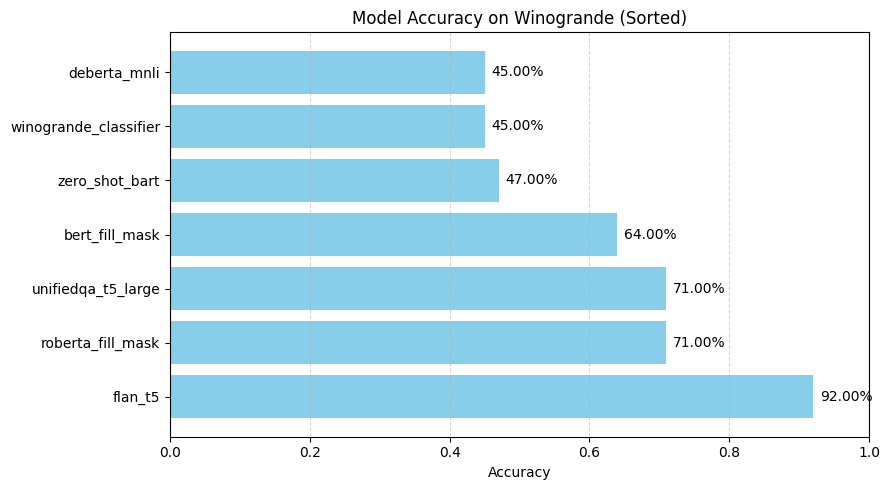

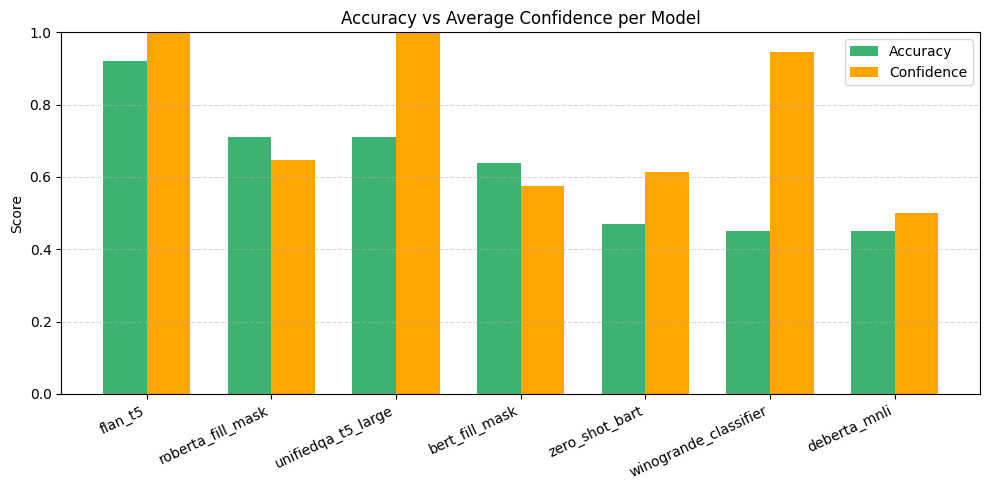

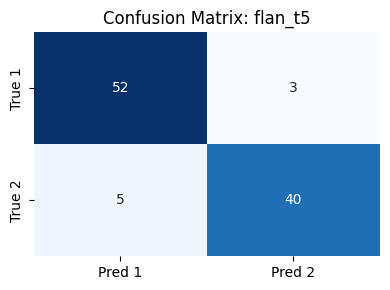

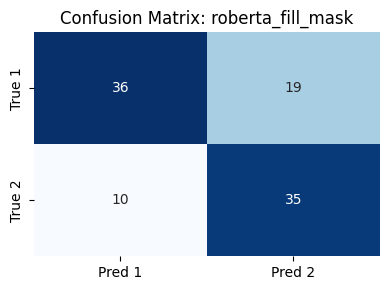

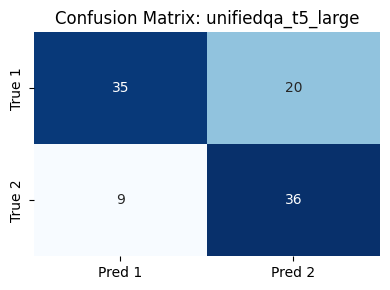

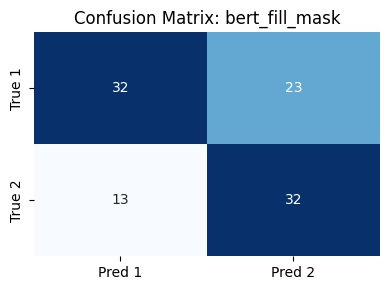

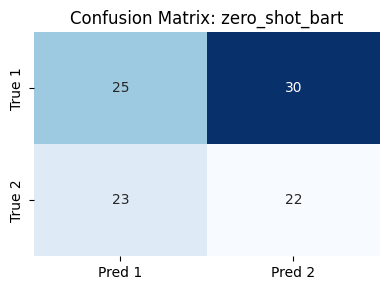

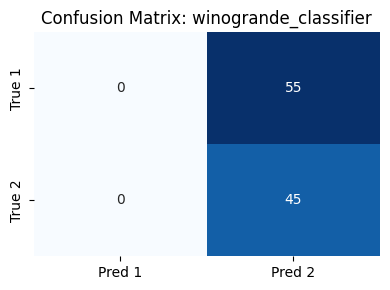

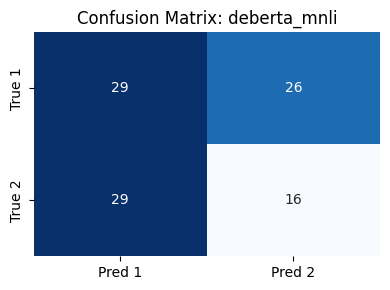

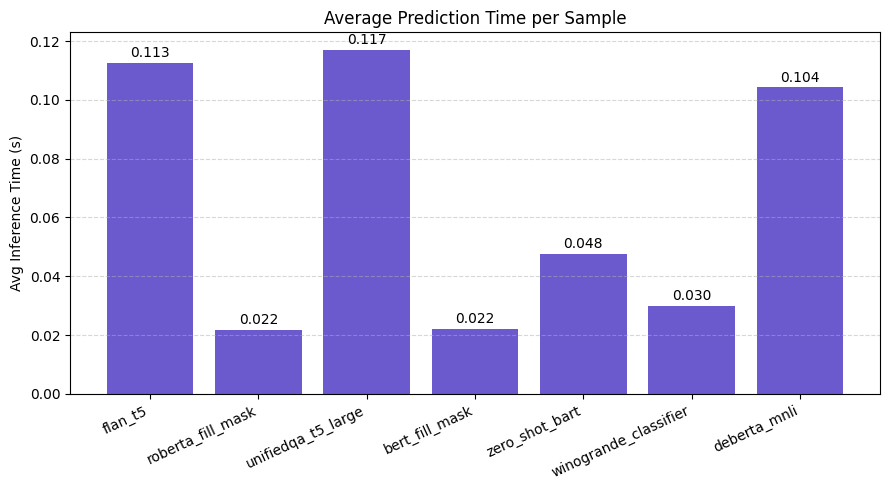

In [ ]:
# Visualize Winogrande model evaluation results (accuracy, confidence, confusion, time)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sort results by accuracy
sorted_items = sorted(results.items(), key=lambda x: x[1]["accuracy"], reverse=True)
model_names = [name for name, _ in sorted_items]
accuracies = [stats["accuracy"] for _, stats in sorted_items]
confidences = [stats["avg_confidence"] for _, stats in sorted_items]
times = [stats["avg_time"] for _, stats in sorted_items]

# 1. Horizontal Bar Chart – Accuracy
plt.figure(figsize=(9, 5))
bars = plt.barh(model_names, accuracies, color="skyblue")
plt.xlabel("Accuracy")
plt.title("Model Accuracy on Winogrande (Sorted)")
plt.grid(axis="x", linestyle="--", alpha=0.5)
for bar, val in zip(bars, accuracies):
    plt.text(val + 0.01, bar.get_y() + bar.get_height() / 2, f"{val:.2%}", va='center')
plt.xlim(0, 1)
plt.tight_layout()
plt.show()
print()

# 2. Grouped Bar Chart – Accuracy vs Confidence
x = range(len(model_names))
width = 0.35
plt.figure(figsize=(10, 5))
plt.bar(x, accuracies, width, label='Accuracy', color='mediumseagreen')
plt.bar([i + width for i in x], confidences, width, label='Confidence', color='orange')
plt.xticks([i + width / 2 for i in x], model_names, rotation=25, ha="right")
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Accuracy vs Average Confidence per Model")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
print()

# 3. Heatmaps – Confusion Matrices
for name, stats in sorted_items:
    cm = pd.DataFrame([[stats["confusion_matrix"][(1, 1)], stats["confusion_matrix"][(1, 2)]],
                       [stats["confusion_matrix"][(2, 1)], stats["confusion_matrix"][(2, 2)]]],
                      index=["True 1", "True 2"], columns=["Pred 1", "Pred 2"])
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix: {name}")
    plt.tight_layout()
    plt.show()
print()

# 4. Inference Time per Sample
plt.figure(figsize=(9, 5))
bars = plt.bar(model_names, times, color="slateblue")
plt.ylabel("Avg Inference Time (s)")
plt.title("Average Prediction Time per Sample")
plt.grid(axis="y", linestyle="--", alpha=0.5)
for i, val in enumerate(times):
    plt.text(i, val + 0.002, f"{val:.3f}", ha='center')
plt.xticks(rotation=25, ha="right")
plt.tight_layout()
plt.show()


### **Winogrande Model Evaluation — Metric-Based Analysis**
---

This analysis evaluates model behavior on the Winogrande dataset using four key metrics: **accuracy**, **confidence**, **confusion matrix**, and **inference time**. Each metric highlights a different dimension of model performance and reasoning quality. Together, they reveal how different model types (e.g., fill-mask, text2text, zero-shot, classification) perform when faced with ambiguous commonsense reasoning tasks.

---

### **1. Accuracy**

Accuracy measures how often the model selected the correct option among the two provided. It serves as the clearest indicator of a model's task-level success.

- The best-performing model was **Flan-T5 (text2text-generation)** with **92% accuracy**, indicating its ability to interpret context and follow instructions closely.
- **RoBERTa (fill-mask)** and **UnifiedQA (text2text)** followed with **71%**, showing strong contextual understanding and transfer learning.
- **BERT (fill-mask)** scored **64%**, while **zero-shot models (BART, DeBERTa)** and the **Winogrande classifier** hovered near **45%**, close to random choice.

These results show that models designed to follow instructions or reason over QA-style prompts perform best, while models that rely on classification objectives or general pretraining alone often fall short unless explicitly aligned to the task structure. Instruction-tuned and generative models are more capable of handling ambiguity and semantic nuance.

---

### **2. Confidence**

Confidence reflects how certain the model is about its choice. It is typically derived from softmax scores (classification), probability distributions (fill-mask), or deterministic output (text2text).

- Both **Flan-T5** and **UnifiedQA** showed confidence values of **1.0**, reflecting strong internal certainty aligned with high accuracy.
- **RoBERTa** and **BERT** showed moderate confidence (**~0.57–0.64**) that roughly tracked their success.
- **Zero-shot models** showed medium confidence, but their predictions were often wrong, revealing potential miscalibration.
- The **Winogrande classifier** had high confidence (**0.95**) despite poor accuracy, indicating it was confidently and consistently wrong.

This shows that confidence alone is not sufficient — what matters is its alignment with correctness. Instruction-based models showed a healthy match between confidence and accuracy, while others, especially zero-shot and classifier-based models, were either overconfident or uncertain in a way that did not reflect actual performance. This suggests that calibration is a key differentiator in model trustworthiness.

---

### **3. Confusion Matrix (Heatmap)**

The confusion matrix provides a breakdown of predictions versus actual labels, allowing us to see not only how many mistakes were made, but what kind.

- A good model will have most of its predictions on the diagonal (True 1 → Pred 1 and True 2 → Pred 2), indicating correct classification.
- **Flan-T5** showed minimal off-diagonal entries, reflecting strong balance across both answer types.
- **RoBERTa** and **UnifiedQA** had some asymmetry but still favored correct predictions.
- **BERT** showed a moderate imbalance with more frequent confusion.
- **Zero-shot models** and the **Winogrande classifier** exhibited strong bias or symmetric confusion — especially the latter, which predicted only one class regardless of input.

These patterns show that confusion matrices are vital for diagnosing not just how many errors a model makes, but whether it’s biased, confused, or guessing. Instruction-tuned models made balanced and reasoned errors, while others often showed signs of structural bias or task mismatch.

---

### **4. Inference Time**

Inference time measures how long each model takes, on average, to produce a prediction. This is essential when balancing performance with scalability or deployment constraints.

- **Fill-mask models (BERT, RoBERTa)** were the fastest, with times around **0.02s per sample**, owing to their efficient token-level predictions and lack of generation overhead.
- **Zero-shot models** and **text-classification** models were moderately fast (**~0.03–0.05s**), balancing multiple scoring passes with efficient model architecture.
- **Text2text-generation models (Flan-T5, UnifiedQA)** were the slowest, averaging around **0.11–0.12s**, due to their generative decoding even when the output is short.

Inference time reveals a trade-off between **speed and reasoning depth**. While generative models are slower, they deliver higher accuracy and better semantic alignment. Fill-mask models are fast and reasonably accurate but may lack deeper reasoning capacity. This suggests that model selection should be guided by use-case needs: fast response or deeper understanding.

---

### **Overall Interpretation**

When combined, these four metrics offer a comprehensive picture of model performance. Accuracy tells us how often models are right. Confidence tells us how sure they are. Confusion matrices tell us how they fail. And inference time tells us how practical they are to run.

Instruction-tuned, generative models like **Flan-T5** and **UnifiedQA** emerge as the most reliable: they are accurate, confident, and make balanced decisions — despite being slower. Fill-mask models like **RoBERTa** offer a strong middle ground in both performance and efficiency. In contrast, zero-shot and classification-only models struggle with accuracy and calibration, making them less suitable for nuanced tasks like Winogrande unless further adapted.


## **Disclaimer**
---

All work submitted in this assignment is **entirely my own**. I independently designed the models, selected parameters, and made all implementation and evaluation decisions.

**AI-based tools were used solely for support purposes**, including:
- **Formatting and organizing** markdown cells for improved clarity,
- **Troubleshooting specific coding issues**,
- **Writing code snippets** based on my own logic and instructions, and
- **Translating content from Greek to English** for documentation and clarity.

At no point was AI used to generate or influence the **core logic**, design choices, or solutions required for the assignment.
